In [2]:
import numpy as np
import numpy.linalg as la
from scipy import spatial
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

$$\phi(x) = (1+a_0) x^2/2 + a_1 x - a_2 \exp \left( - \frac{1}{2} [a_3(x+a_4)]^2 \right)$$ yielding
$$
T(x) =  (1+a_0) x + a_1 + a_2 a_3^2 (x+a_4) \exp \left( - \frac{1}{2}[a_3(x+a_4)]^2 \right)\\
 = T_0(x) + T_1(x)
$$
and  
$$
g(z) =\frac{1}{2} \beta_0 z^2 + \beta_1 z + \beta_2 + \beta_3 \exp \left( -\frac{1}{2}[\beta_4(z+\beta_5)]^2 \right) + \beta_6 \exp \left( -\frac{1}{2}[\beta_7(z+\beta_8)]^2 \right) \\
 = g_0(z) + g_1(z) + g_2(z)
$$

Penalization:
$\beta_0,..,\beta_3$ and $\beta_6$: unpenalized. $\beta_4, \beta_7$: penalized as $\sim \exp((\epsilon \beta_j)^2)$. $\beta_5, \beta_8$ penalized as $\sim (\beta_k/D)^2$.

$a_0$ penalized as $\sim a_0^2$. $a_1,a_4$ penalized as $\sim (a_i/D)^2$. $a_2$ penalized as $a_2^2$ and $a_3$ penalized as $\sim \exp((\epsilon a_3)^2)$.

where $D$ is an estimate of the size of the support of the data (e.g. std), $\epsilon = \max_i \min_j |x_i-y_j|$

# Data samples

In [3]:
Nx = 500
Ny = 490

#Guassians
x = np.random.normal(0,1,Nx)
y = np.random.normal(-1,1,Ny)

#Gaussian to mixed Gaussian
x = np.random.normal(0,1,Nx)
y1 = np.random.normal(-3,0.75,int(Ny/2))
y2 = np.random.normal(3,0.75,int(Ny/2))
y3 = np.random.normal(0,0.75,int(Ny/2))
y = np.concatenate([y1,y2,y3],axis=0)

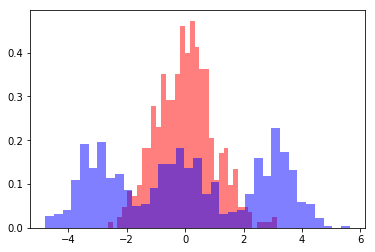

In [4]:
bins = 35
plt.hist(x,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

# Local Algorithm

## GH

In [5]:
try:
    Nx,d = x.shape
except ValueError:
    Nx = len(x)
    d = 1
Ny = len(y)
da = 2+2*d+d**2
db = 3*d+6

#Precomputed data, (twisted) gradient and Hessian
xh = np.concatenate([x.reshape(Nx,d),np.ones((Nx,d))],axis=1)

gammaA = 2*1e-1 #alpha regularization parameter 
gammaB = 2*1e-1 #beta regularization parameter

def GH(a,b,eps,D):

    #precomputations
    Tx0 = (1+a[0])*x+a[1] 
    xa4 = x + a[4]
    a3xa4 = a[3]*xa4
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = a[2]*a[3]*a3xa4*expo
    Tx = Tx0 + Tx1
    
    g0y = 0.5*b[0]*y**2 + b[1]*y + b[2]
    argexpy1 =  (b[4]*(y + b[5]))**2
    expoy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  (b[7]*(y + b[8]))**2
    expoy2 = np.exp(-0.5*argexpy2)
    g1y = b[3]*expoy1
    g2y = b[6]*expoy2
    gy = g0y + g1y + g2y
    g0Tx = 0.5*b[0]*Tx**2 + b[1]*Tx + b[2]
    argexpT1 =  (b[4]*(Tx + b[5]))**2
    expoT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  (b[7]*(Tx + b[8]))**2
    expoT2 = np.exp(-0.5*argexpT2)
    g1Tx = b[3]*expoT1
    g2Tx = b[6]*expoT2
    gTx = g0Tx + g1Tx + g2Tx   
    
    g0pTx = b[0]*Tx + b[1]
    g1pTx = -b[4]**2 * (Tx+b[5])*g1Tx
    g2pTx = -b[7]**2 * (Tx+b[8])*g2Tx
    gpTx = g0pTx + g1pTx + g2pTx
    
    daT = np.zeros((Nx,da))
    daT[:,0] = x
    daT[:,1] = np.ones(Nx)
    daT[:,2] = expo*a[3]*a3xa4
    daT[:,3] = a[2] * a3xa4 * expo * (2.0 - a3xa42)
    daT[:,4] = a[2]*a[3]**2 * expo * (1.0 - a3xa42)

    #gradient w.r.t. a
    penalty_a = np.array([0*a[0],0*a[1]/D**2,0*a[2],eps**2*a[3]*np.exp((eps*a[3])**2)-1.0/(D**2 * a[3]**3),1*a[4]/(10*D**2)]) 
    daL = (1.0/Nx) * np.einsum('i,ik->k',gpTx,daT) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penalty_a

    expgy = np.exp(gy)
    dbgy = np.zeros((Ny,db))
    dbgT = np.zeros((Nx,db))
    dbgy[:,0] = 0.5*y**2
    dbgT[:,0] = 0.5*Tx**2
    dbgy[:,1] = y
    dbgT[:,1] = Tx
    dbgy[:,2] = np.ones(Ny)
    dbgT[:,2] = np.ones(Nx) 
    dbgy[:,3] = expoy1
    dbgT[:,3] = expoT1
    dbgy[:,4] = -b[4]*(y+b[5])**2 * g1y
    dbgT[:,4] = -b[4]*(Tx+b[5])**2 * g1Tx
    dbgy[:,5] = -b[4]**2 * (y+b[5])*g1y
    dbgT[:,5] = -b[4]**2 * (Tx+b[5])*g1Tx
    dbgy[:,6] = expoy2
    dbgT[:,6] = expoT2
    dbgy[:,7] = -b[7]*(y+b[8])**2 * g2y
    dbgT[:,7] = -b[7]*(Tx+b[8])**2 * g2Tx
    dbgy[:,8] = -b[7]**2 * (y+b[8])*g2y
    dbgT[:,8] = -b[7]**2 * (Tx+b[8])*g2Tx
    #gradient w.r.t. b
    penalty_b = np.array([0,0,0,0,eps**2*b[4]*np.exp((eps*b[4])**2)-1*1/(D**2 *b[4]**3),1*b[5]/(10*D**2)-1*2*eps**2 *(b[5]-b[8])**(-3),0,eps**2*b[7]*np.exp((eps*b[7])**2)-1*1/(D**2 *b[7]**3),1*b[8]/(10*D**2)+ 1*2*eps**2 *(b[5]-b[8])**(-3)])
    dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

    #twisted gradient
    G = np.concatenate([daL,-dbL],axis=0)

    g0ppTx = b[0]*np.ones(Nx)
    g1ppTx = -b[4]**2 *g1Tx*(1.0-b[4]**2 * (Tx+b[5]))
    g2ppTx = -b[7]**2 *g2Tx*(1.0-b[7]**2 * (Tx+b[8]))
    gppTx = g0ppTx+g1ppTx+g2ppTx
    
    daaT = np.zeros((Nx,da,da))
    daaT[:,2,3] = a3xa4 * expo * (2.0 - a3xa42)
    daaT[:,2,4] = a[3]**2 * expo * (1.0 - a3xa42)
    daaT[:,3,3] = a[2] * xa4 * expo * (2.0-3*a3xa42-a3xa42*(2.0-a3xa42))
    daaT[:,3,4] = a[2]*a[3] * expo * (2.0 + a3xa42*(a3xa42-5.0))
    daaT[:,4,4] = -a[2]*a[3]**4 *xa4 * expo * (3.0 + a3xa42)
    #Hessian w.r.t. aa
#     penaltyH_a = np.eye(da)
#     penaltyH_a[1,1] = 1.0/D**2
    penaltyH_a = np.zeros((da,da))
    penaltyH_a[4,4] = 1*1.0/(10*D**2)
    penaltyH_a[3,3] = eps**2 * np.exp((a[3]*eps)**2)*(1.0+2.0*a[3]*eps**2) + 3/(D**2 * a[3]**4)
    daaL = (1.0/Nx)*(np.einsum('i,ikl->kl',gpTx,daaT) + np.einsum('i,ik,il->kl',gppTx,daT,daT)) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penaltyH_a

    dbgpTx = np.zeros((Nx,db))
    dbgpTx[:,0] = Tx
    dbgpTx[:,1] = np.ones(Nx)
    dbgpTx[:,3] = -b[4]**2 * (Tx+b[5]) * expoT1
    dbgpTx[:,4] = b[4]*b[3]*(Tx+b[5])*expoT1*(-2.0+b[4]**2 * (Tx+b[5])**2)
    dbgpTx[:,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
    dbgpTx[:,6] = -b[7]**2 * (Tx+b[8]) * expoT2
    dbgpTx[:,7] = b[7]*b[6]*(Tx+b[8])*expoT2*(-2.0+b[7]**2 * (Tx+b[8])**2)
    dbgpTx[:,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
    
    #Hessian w.r.t. ab
    dabL = (1.0/Nx)*np.einsum('in,ik->kn',dbgpTx,daT)

    dbbgy = np.zeros((Ny,db,db))
    dbbgT = np.zeros((Nx,db,db))
    dbbgy[:,3,4] = -b[4]*(y+b[5])**2 * expoy1
    dbbgT[:,3,4] = -b[4]*(Tx+b[5])**2 * expoT1
    dbbgy[:,3,5] = -b[4]**2 * (y+b[5])* expoy1
    dbbgT[:,3,5] = -b[4]**2 * (Tx+b[5])* expoT1
    dbbgy[:,4,4] = b[3]*(y+b[5])**2 * expoy1 * (-1.0+argexpy1)
    dbbgT[:,4,4] = b[3]*(Tx+b[5])**2 * expoT1 * (-1.0+argexpT1)
    dbbgy[:,4,5] = b[3]*b[4]*(y+b[5])*expoy1*(-2.0+b[4]*(y+b[5]))
    dbbgT[:,4,5] = b[3]*b[4]*(Tx+b[5])*expoT1*(-2.0+b[4]*(Tx+b[5]))
    dbbgy[:,5,5] = b[3]*b[4]**2 * expoy1*(-1.0+argexpy1)
    dbbgT[:,5,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
    dbbgy[:,6,7] = -b[7]*(y+b[8])**2 * expoy2
    dbbgT[:,6,7] = -b[7]*(Tx+b[8])**2 * expoT2
    dbbgy[:,6,8] = -b[7]**2 * (y+b[8])* expoy2
    dbbgT[:,6,8] = -b[7]**2 * (Tx+b[8])* expoT2
    dbbgy[:,7,7] = b[6]*(y+b[8])**2 * expoy2 * (-1.0+argexpy2)
    dbbgT[:,7,7] = b[6]*(Tx+b[8])**2 * expoT2 * (-1.0+argexpT2)
    dbbgy[:,7,8] = b[6]*b[7]*(y+b[8])*expoy2*(-2.0+b[7]*(y+b[8]))
    dbbgT[:,7,8] = b[6]*b[7]*(Tx+b[8])*expoT2*(-2.0+b[7]*(Tx+b[8]))
    dbbgy[:,8,8] = b[6]*b[7]**2 * expoy2*(-1.0+argexpy2)
    dbbgT[:,8,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
    #symmetrize tensors
    dbbgy = dbbgy + np.transpose(dbbgy,(0,2,1))
    dbbgy[:,np.arange(db),np.arange(db)] *= 0.5
    dbbgT = dbbgT + np.transpose(dbbgT,(0,2,1))
    dbbgT[:,np.arange(db),np.arange(db)] *= 0.5

    dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
    #Hessian w.r.t. bb
    penaltyH_b = np.zeros((db,db))
    penaltyH_b[5,5] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[8,8] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[5,8] = -1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[8,5] = -1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[4,4] = eps**2 * np.exp((b[4]*eps)**2)*(1.0+2.0*b[4]*eps**2) + 1*3/(D**2 * b[4]**4)
    penaltyH_b[7,7] = eps**2 * np.exp((b[7]*eps)**2)*(1.0+2.0*b[7]*eps**2) + 1*3/(D**2 * b[7]**4)
    dbbL = (1.0/Nx)*np.sum(dbbgT,axis=0) - (1.0/Ny)*np.einsum('jnm,j->nm',(dbbgy+dbgdbg),expgy) - gammaB*penaltyH_b

    #Twisted Hessian
    H = np.zeros((da+db,da+db))
    H[:da,:da] = daaL
    H[:da,da:] = dabL
    H[da:,:da] = -dabL.T
    H[da:,da:] = -dbbL
    return(G,H)

/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide


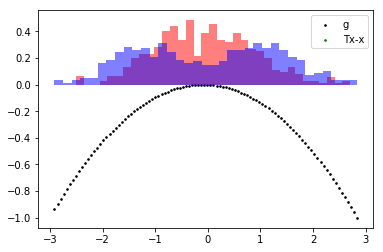

a= [0.         0.         0.         0.87969224 0.        ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.54228714 -0.04746807 -0.00122977] b0z^2+b1z+b2
b gauss1= [0.         0.87969224 0.35808519] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.         0.87969224 0.82823913] b6exp(-(b7(z+b8))^2/2)
Step n= 0


/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


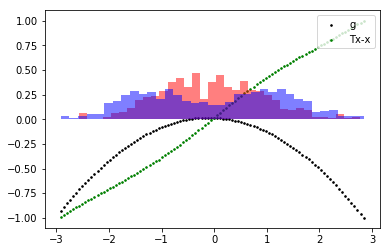

a= [0.02481432 0.00131034 0.00908479 0.87995053 0.        ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.53937434 -0.04793899  0.01352318] b0z^2+b1z+b2
b gauss1= [0.01317219 0.89055134 0.35661775] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.01135426 0.89052329 0.82869275] b6exp(-(b7(z+b8))^2/2)
Step n= 1


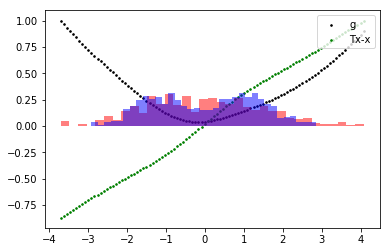

a= [4.81070881e-01 4.17460946e-02 1.86637771e-01 8.95655430e-01
 3.81245541e-05] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.07341137 -0.02293175  0.1116616 ] b0z^2+b1z+b2
b gauss1= [-0.05419141  1.09304379  0.31591021] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.04808749  1.09585072  0.84566425] b6exp(-(b7(z+b8))^2/2)
Step n= 2


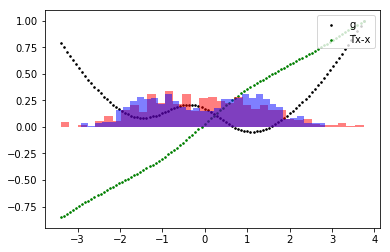

a= [0.36159044 0.04070583 0.16838117 0.90876439 0.00677959] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.05693037 -0.0006307  -0.0741491 ] b0z^2+b1z+b2
b gauss1= [0.13629283 1.33352962 0.26832437] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.00230648 1.30453553 0.83772271] b6exp(-(b7(z+b8))^2/2)
Step n= 3


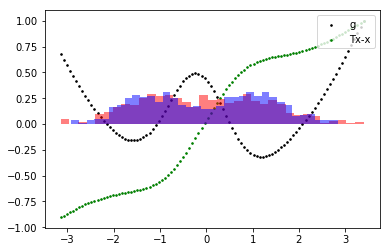

a= [0.24366263 0.01195975 0.37590496 1.02733114 0.04964652] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.10397877  0.00564448 -0.23769147] b0z^2+b1z+b2
b gauss1= [0.37890362 1.61473546 0.153767  ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.06603349 1.55036881 0.75623991] b6exp(-(b7(z+b8))^2/2)
Step n= 4


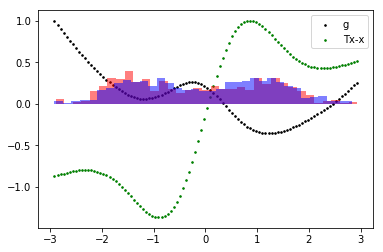

a= [ 0.11368402 -0.08643808  0.62871906  1.25341049  0.01967848] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.12748823 -0.06755932 -0.2183448 ] b0z^2+b1z+b2
b gauss1= [0.32027225 1.73995193 0.11512942] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.03125611 1.68418059 0.74008281] b6exp(-(b7(z+b8))^2/2)
Step n= 5


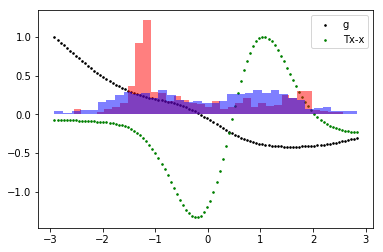

a= [-0.01773076 -0.09174876  0.75296675  1.55412631 -0.42352428] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.08201845 -0.12789794 -0.14317955] b0z^2+b1z+b2
b gauss1= [0.08563596 1.85148387 0.15991224] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.07053837 1.78603656 0.74542399] b6exp(-(b7(z+b8))^2/2)
Step n= 6


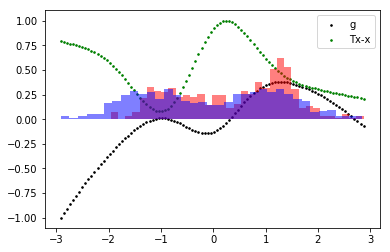

a= [-0.0742525   0.36920473  0.43140461  1.48350202  0.3874453 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.20105373  0.14247329  0.35483794] b0z^2+b1z+b2
b gauss1= [-0.18990297  2.03187236 -0.22048807] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.31889753  1.91502732  0.18404827] b6exp(-(b7(z+b8))^2/2)
Step n= 7


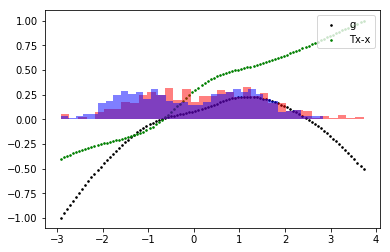

a= [0.27171163 0.2823099  0.19204659 1.23091521 0.32410294] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.18869364  0.15348987  0.20688065] b0z^2+b1z+b2
b gauss1= [-0.08172127  2.08553691 -0.28124026] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.0603717   1.98595484  0.23472256] b6exp(-(b7(z+b8))^2/2)
Step n= 8


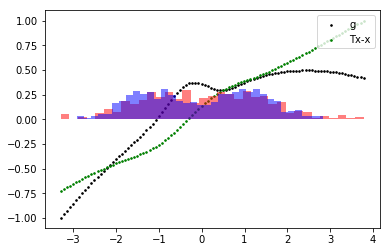

a= [0.35440116 0.11538146 0.18659669 1.23154643 0.3372677 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.02242456  0.05513256  0.05532137] b0z^2+b1z+b2
b gauss1= [-0.02927885  2.14384607 -0.2836831 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.06590383 2.05806977 0.25165482] b6exp(-(b7(z+b8))^2/2)
Step n= 9


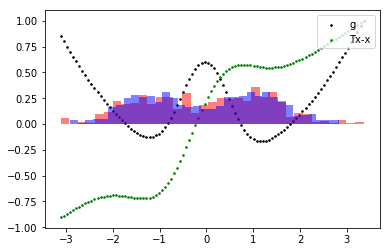

a= [0.2365262  0.00983848 0.38779402 1.30604483 0.29130349] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.04724071 -0.00151378 -0.07313401] b0z^2+b1z+b2
b gauss1= [ 0.0970971   2.25702095 -0.21853843] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.11438883 2.17808692 0.24527374] b6exp(-(b7(z+b8))^2/2)
Step n= 10


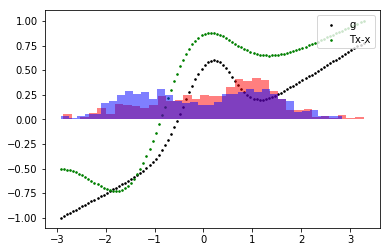

a= [0.14628718 0.16982433 0.53297436 1.2064389  0.82881124] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00308397  0.12956398 -0.08776181] b0z^2+b1z+b2
b gauss1= [ 0.24208537  2.41194213 -0.27268331] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.15577173 2.37270371 0.21559343] b6exp(-(b7(z+b8))^2/2)
Step n= 11


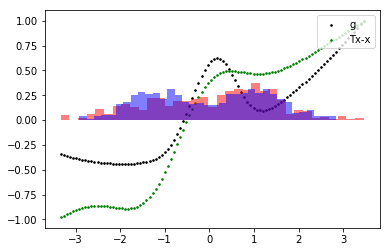

a= [ 2.76687489e-01 -6.32069964e-04  5.37425487e-01  1.19384816e+00
  6.81075479e-01] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.03979968  0.07676686 -0.10254783] b0z^2+b1z+b2
b gauss1= [ 0.24300778  2.41794206 -0.2722704 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.15938881 2.38055118 0.21587914] b6exp(-(b7(z+b8))^2/2)
Step n= 12


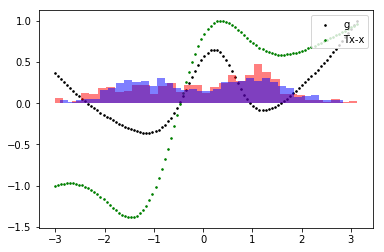

a= [ 0.16165453 -0.01040844  0.63299722  1.2523506   0.55396699] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.07562275  0.02854241 -0.14153676] b0z^2+b1z+b2
b gauss1= [ 0.26843558  2.44698914 -0.31487044] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.1336743  2.43068445 0.20050168] b6exp(-(b7(z+b8))^2/2)
Step n= 13


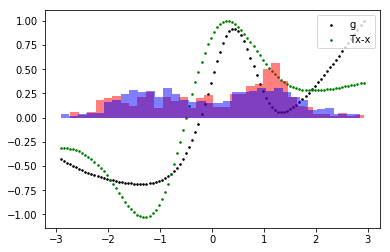

a= [0.06856353 0.02560731 0.73579973 1.31045284 0.50685581] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.03281337  0.04193906 -0.09092268] b0z^2+b1z+b2
b gauss1= [ 0.2167856   2.49498688 -0.41012417] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.03789514 2.5237995  0.19163719] b6exp(-(b7(z+b8))^2/2)
Step n= 14


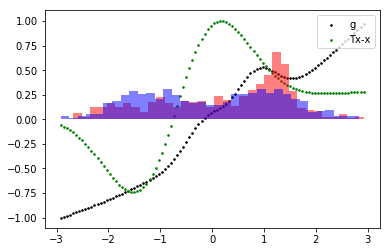

a= [0.03317927 0.1259981  0.90567003 1.20447138 0.67577916] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.02226255  0.13410889 -0.10208322] b0z^2+b1z+b2
b gauss1= [ 0.18130685  2.58013111 -0.83745931] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.12052653 2.70088284 0.13203256] b6exp(-(b7(z+b8))^2/2)
Step n= 15


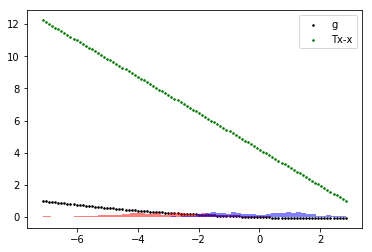

a= [ 0.73928143 -2.75661443  0.08032162  0.18196486 -3.02586479] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.80278723 -1.60317852 -0.13207593] b0z^2+b1z+b2
b gauss1= [-0.37152443  2.6388268  -0.29016967] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.12359312 2.70720953 0.15764145] b6exp(-(b7(z+b8))^2/2)
Step n= 16


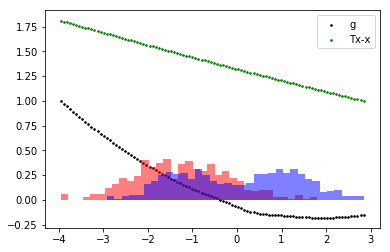

a= [ 0.10836788 -1.19987534 -0.17882473  0.23964558 -3.01797163] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.76248058 -1.46057248 -0.61349859] b0z^2+b1z+b2
b gauss1= [-0.36034129  2.64271055 -0.29219594] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.12335259 2.71450571 0.14954365] b6exp(-(b7(z+b8))^2/2)
Step n= 17


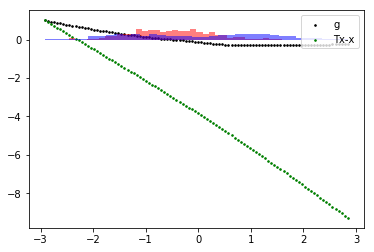

a= [-0.21768238 -0.5437765  -0.32897982  0.31578164 -3.01693546] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.72204542 -1.19029333 -0.76708984] b0z^2+b1z+b2
b gauss1= [-0.29045757  2.65510023 -0.32985301] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.22496737 2.71771183 0.14164404] b6exp(-(b7(z+b8))^2/2)
Step n= 18


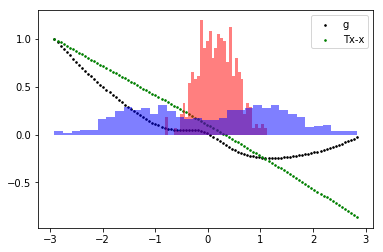

a= [-0.62551124  0.08329354 -0.49148767  0.38354257 -3.01076671] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.69105197 -0.78927878 -0.67190957] b0z^2+b1z+b2
b gauss1= [ 0.06620598  2.67555907 -0.37333699] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.70161153 2.67746043 0.11154729] b6exp(-(b7(z+b8))^2/2)
Step n= 19


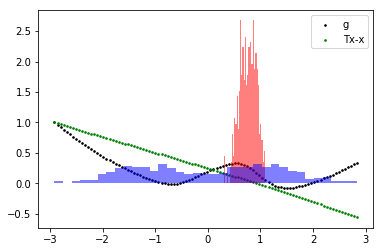

a= [-0.84852682  0.64359507 -0.57319515  0.42331469 -3.0162981 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.66951353 -0.35149781 -0.5823776 ] b0z^2+b1z+b2
b gauss1= [ 1.01290891  2.60731364 -0.05937975] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.40466765  2.78998486 -0.6821872 ] b6exp(-(b7(z+b8))^2/2)
Step n= 20


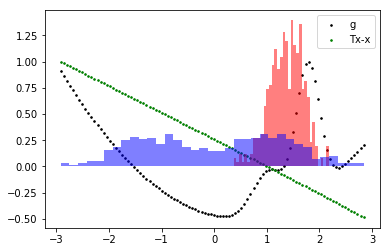

a= [-1.34793663  1.29006908 -0.28057337  0.42425781 -3.14000954] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.56685195 -0.25970437 -1.06978919] b0z^2+b1z+b2
b gauss1= [ 0.95970222  3.3207986  -1.02754865] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.89694072  4.62162145 -1.77708974] b6exp(-(b7(z+b8))^2/2)
Step n= 21


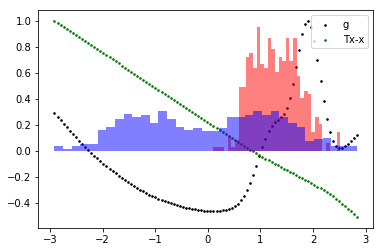

a= [-1.51468978  1.23253701 -0.52466505  1.2042917  -3.08999856] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.38195381 -0.05480137 -1.09658214] b0z^2+b1z+b2
b gauss1= [ 1.32153451  3.30847656 -1.25829848] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.74521447  4.3819774  -1.90565413] b6exp(-(b7(z+b8))^2/2)
Step n= 22


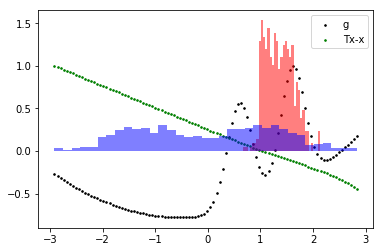

a= [-1.3268865   1.31388545 -0.47377934  1.17011651 -3.13359893] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.31903373  0.15616177 -1.40804018] b0z^2+b1z+b2
b gauss1= [ 2.31058099  4.12017186 -0.60318208] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.59822308  4.25774796 -1.60922489] b6exp(-(b7(z+b8))^2/2)
Step n= 23


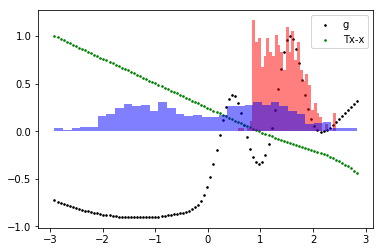

a= [-1.43444317  1.35372621 -0.63723255  1.28619795 -3.16108521] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.27666173  0.36612565 -1.52987342] b0z^2+b1z+b2
b gauss1= [ 2.08250573  3.98850688 -0.45305043] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.58054478  4.27152769 -1.54944448] b6exp(-(b7(z+b8))^2/2)
Step n= 24


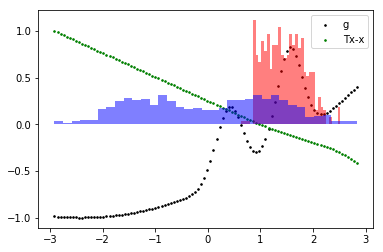

a= [-1.44405618  1.40869463 -0.62802838  1.33240174 -3.178456  ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.23790567  0.57937586 -1.65552668] b0z^2+b1z+b2
b gauss1= [ 1.84061118  3.94845936 -0.40172914] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.40879317  4.0707364  -1.54549686] b6exp(-(b7(z+b8))^2/2)
Step n= 25


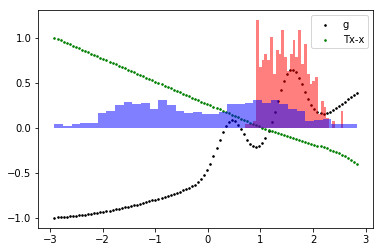

a= [-1.4442119   1.46521094 -0.61855976  1.353263   -3.18317575] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.21263265  0.72564109 -1.76291752] b0z^2+b1z+b2
b gauss1= [ 1.65296092  3.96166407 -0.43064287] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.27662129  3.8608803  -1.56675183] b6exp(-(b7(z+b8))^2/2)
Step n= 26


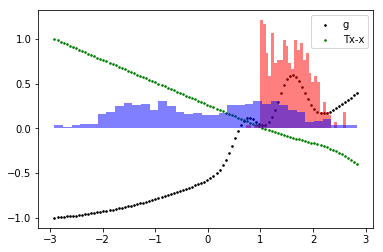

a= [-1.44724867  1.50313556 -0.67197165  1.35411102 -3.10632744] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.22224932  0.77603682 -1.84824754] b0z^2+b1z+b2
b gauss1= [ 1.54336679  3.982028   -0.73279962] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.22876572  3.76754997 -1.57184528] b6exp(-(b7(z+b8))^2/2)
Step n= 27


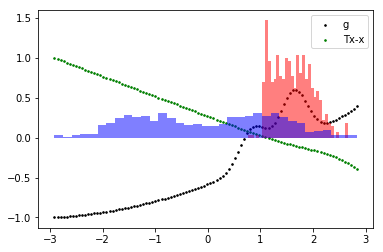

a= [-1.44402266  1.55052146 -0.6784912   1.346418   -3.0919695 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.22432975  0.78289206 -1.87529191] b0z^2+b1z+b2
b gauss1= [ 1.52450521  3.98382206 -0.85279618] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.21525101  3.74491581 -1.62377973] b6exp(-(b7(z+b8))^2/2)
Step n= 28


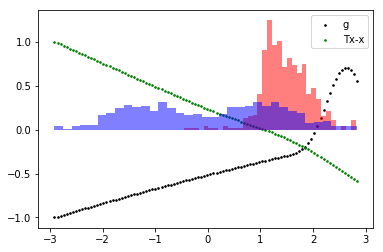

a= [-1.59779618  1.31150439 -0.77451476  1.00616664 -2.5158627 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.03603749  0.57132408 -1.92880855] b0z^2+b1z+b2
b gauss1= [ 1.88816252  4.1635793  -2.78858695] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.17959107  3.71688314 -2.43572817] b6exp(-(b7(z+b8))^2/2)
Step n= 29


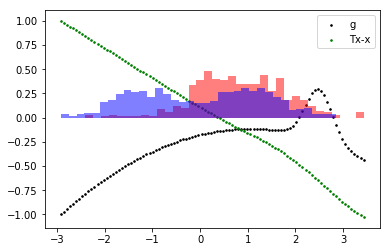

a= [-2.0957381   0.68374041 -0.77126015  1.07700906 -2.56514913] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.69399385  0.72485994 -1.09342896] b0z^2+b1z+b2
b gauss1= [ 1.5283761   3.96327168 -2.38961588] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.87166904  3.6684202  -2.56328863] b6exp(-(b7(z+b8))^2/2)
Step n= 30


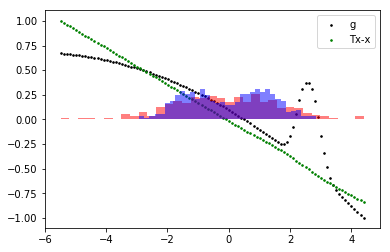

a= [-2.86904379 -0.27843417 -0.43401042  1.1551316  -2.44987175] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.09293077 -0.58742291  0.30648678] b0z^2+b1z+b2
b gauss1= [ 1.54082342  3.96322327 -2.39632115] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.9115078   3.70208865 -2.75900741] b6exp(-(b7(z+b8))^2/2)
Step n= 31


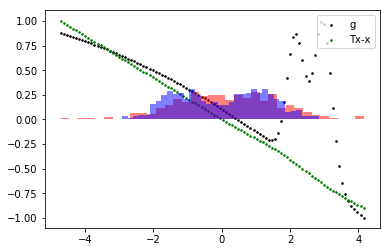

a= [-2.66657235 -0.01712219 -0.52343826  1.12106959 -2.42090318] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.02738259 -0.25845994  0.1271103 ] b0z^2+b1z+b2
b gauss1= [ 1.50923608  3.9958884  -2.16745026] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.92971945  3.74556899 -2.95411213] b6exp(-(b7(z+b8))^2/2)
Step n= 32


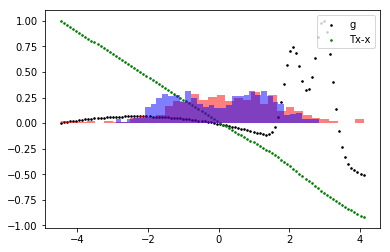

a= [-2.60682293  0.07733407 -0.55107079  1.1074148  -2.40159694] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.04125724 -0.09511779 -0.01191109] b0z^2+b1z+b2
b gauss1= [ 1.38581359  4.02127752 -2.10647639] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.94363385  3.75807045 -2.95857747] b6exp(-(b7(z+b8))^2/2)
Step n= 33


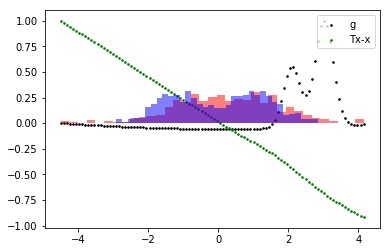

a= [-2.61965713  0.09574367 -0.56343646  1.13759624 -2.39349707] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.01044552 -0.00151612 -0.10854939] b0z^2+b1z+b2
b gauss1= [ 1.13925413  4.07880338 -2.10273012] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.97485108  3.79600556 -3.01481603] b6exp(-(b7(z+b8))^2/2)
Step n= 34


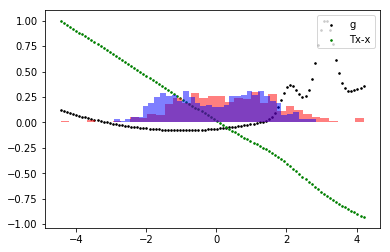

a= [-2.61227243  0.15747049 -0.60398028  1.24310668 -2.46424225] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.08306834  0.07832857 -0.16033771] b0z^2+b1z+b2
b gauss1= [ 0.74661932  4.15819664 -2.09919231] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.08200233  3.88880722 -3.09440828] b6exp(-(b7(z+b8))^2/2)
Step n= 35


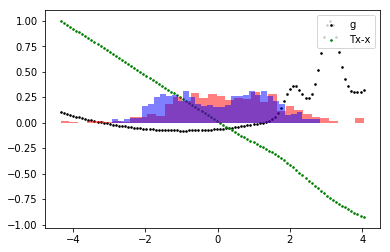

a= [-2.564681    0.11992371 -0.60413843  1.24367839 -2.46447008] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.07961588  0.07660492 -0.1605356 ] b0z^2+b1z+b2
b gauss1= [ 0.74495402  4.15860928 -2.09827679] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.08209954  3.88909059 -3.09447486] b6exp(-(b7(z+b8))^2/2)
Step n= 36


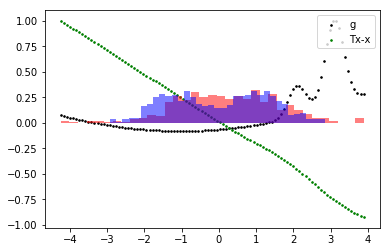

a= [-2.51658088  0.0826365  -0.60426099  1.24423137 -2.4646872 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.07288281  0.07324723 -0.16027462] b0z^2+b1z+b2
b gauss1= [ 0.74307798  4.15906411 -2.09646796] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.0819187   3.88946955 -3.09590116] b6exp(-(b7(z+b8))^2/2)
Step n= 37


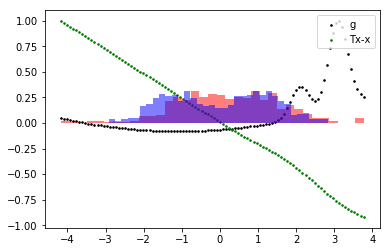

a= [-2.48228688  0.05540071 -0.60433511  1.24470893 -2.46489011] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.06466308  0.06914189 -0.15948993] b0z^2+b1z+b2
b gauss1= [ 0.74110249  4.15948279 -2.09432341] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.08164448  3.88990801 -3.09827085] b6exp(-(b7(z+b8))^2/2)
Step n= 38


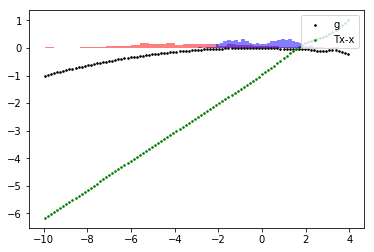

a= [ 1.7045107  -3.17592311 -0.59662293  1.24719458 -2.46462493] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.48499242 -0.22375837 -0.08551207] b0z^2+b1z+b2
b gauss1= [ 0.68911835  4.1586789  -2.0329507 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.05660347  3.90089731 -3.37104863] b6exp(-(b7(z+b8))^2/2)
Step n= 39


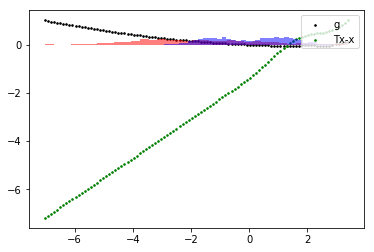

a= [ 1.0591347  -1.86858912 -0.6561446   1.15285381 -2.31733137] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.36369117 -0.75944707 -0.13739859] b0z^2+b1z+b2
b gauss1= [ 0.68434054  4.16083841 -2.03089411] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.06189993  3.89973235 -3.32698836] b6exp(-(b7(z+b8))^2/2)
Step n= 40


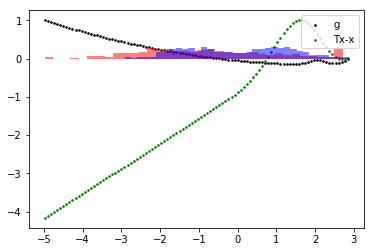

a= [ 0.62981446 -0.88925921 -1.04643454  1.40415379 -2.16366526] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.27960853 -0.60405547 -0.29010416] b0z^2+b1z+b2
b gauss1= [ 0.69719011  4.16419792 -2.05664406] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.06840457  3.90201655 -3.18718138] b6exp(-(b7(z+b8))^2/2)
Step n= 41


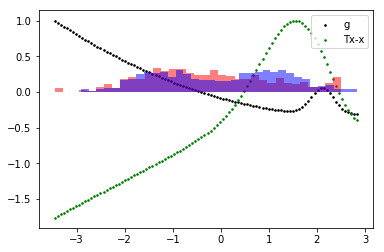

a= [ 0.24001389 -0.35378842 -0.92488046  1.19136409 -2.26904576] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.14149527 -0.35599836 -0.16369237] b0z^2+b1z+b2
b gauss1= [ 0.70351428  4.15574643 -2.1114321 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.0198746   3.81114481 -3.75207747] b6exp(-(b7(z+b8))^2/2)
Step n= 42


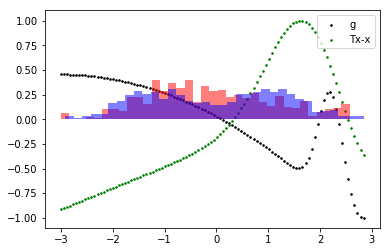

a= [ 0.13406093 -0.16425548 -0.79818985  1.18360248 -2.38302612] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.06210274 -0.1866609   0.01965265] b0z^2+b1z+b2
b gauss1= [ 0.72029533  4.16187632 -2.19990686] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.01978795  3.82290673 -3.50322999] b6exp(-(b7(z+b8))^2/2)
Step n= 43


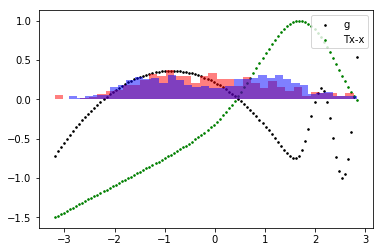

a= [ 0.18601746 -0.22431529 -0.70537257  1.09972438 -2.43918351] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.18321912 -0.15935644  0.09731394] b0z^2+b1z+b2
b gauss1= [ 0.72424694  4.16770477 -2.15819643] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 2.01706783  3.84091063 -3.07919199] b6exp(-(b7(z+b8))^2/2)
Step n= 44


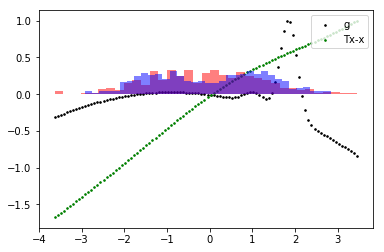

a= [ 0.38961371 -0.21787085 -0.68582573 -0.47383723 -2.11380753] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.13447873 -0.11951447 -0.01327531] b0z^2+b1z+b2
b gauss1= [ 0.24188754  4.00661083 -1.04587077] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.94838074  4.94307485 -1.84547941] b6exp(-(b7(z+b8))^2/2)
Step n= 45


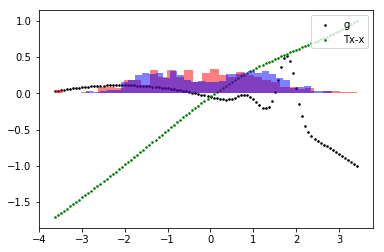

a= [ 0.38164012 -0.21698338 -0.5508467  -0.52518447 -2.06263734] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.09946403 -0.20945836 -0.06772098] b0z^2+b1z+b2
b gauss1= [ 0.24429663  4.04345241 -0.86879446] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 1.31079924  4.77723399 -1.78990191] b6exp(-(b7(z+b8))^2/2)
Step n= 46


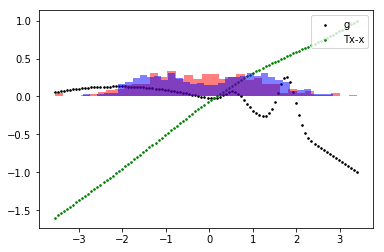

a= [ 0.35642487 -0.18404632 -0.38099053 -0.56445263 -2.01392383] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.06898686 -0.14533184 -0.03007496] b0z^2+b1z+b2
b gauss1= [ 0.18531936  4.12449728 -0.59533306] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 0.63700735  4.79984247 -1.78676582] b6exp(-(b7(z+b8))^2/2)
Step n= 47


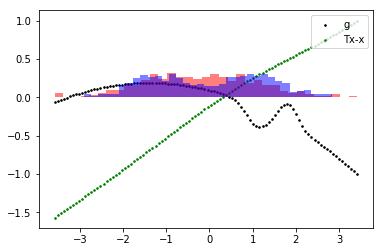

a= [ 0.359855   -0.19619098 -0.26000076 -0.580848   -1.96677334] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.08645193 -0.11922663  0.07592809] b0z^2+b1z+b2
b gauss1= [-0.2102864   4.06608471 -1.10516372] b3exp(-(b4(z+b5))^2/2)
b gauss2= [ 0.2177957   4.87982581 -1.83856207] b6exp(-(b7(z+b8))^2/2)
Step n= 48


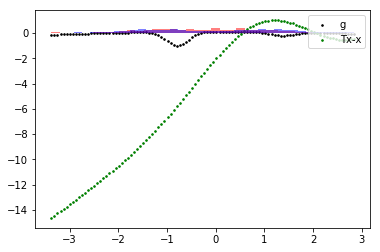

a= [ 0.20105782 -0.37177257 -0.58880812 -0.73739004 -1.93021362] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.09017812  0.00444131  0.22288703] b0z^2+b1z+b2
b gauss1= [-0.58135764  4.04195929 -1.37281549] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-2.27677255  4.46204251  0.78665968] b6exp(-(b7(z+b8))^2/2)
Step n= 49
done


In [27]:
#local minimax algorithm, rejction using G, update eta with D
Niter = 50
eps = 1e-6
eta0 = 0.05
eta = eta0
etaC = 2.0


#setting up initial b, and minvar,D
vx = np.var(x)
vy = np.var(y)
mx = np.mean(x)
my = np.mean(y)
vxy = np.var(np.concatenate([x,y]))
D = np.sqrt(vxy)
mxy = np.mean(np.concatenate([x,y]))
#initial a
a0 = np.zeros(da)
a0[3] = 1/D
#initial b
b00 = np.array([1.0/vy -1.0/vx,mx/vx - my/vy,0.5*(my**2/vy-mx**2/vx)])
b01 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
b01[0] = 0
b01[1] = 1/D
b02 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
b02[0] = 0
b02[1] =1/D
b0 = np.concatenate([b00,b01,b02])
z = np.concatenate([a0,b0],axis=0)
I = np.eye(da+db)
minvar0 = 1e-12
x0 = np.zeros((Nx,2))
x0[:,0] = x
y0 = np.zeros((Ny,2))
y0[:,0] = y
dsq = spatial.distance.cdist(x0,y0,'sqeuclidean')
minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
delta0 = np.sqrt(minvar)
dsq2 = spatial.distance.cdist(x0,x0,'sqeuclidean')
dsq2 += 100*np.eye(Nx)
minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
deltainf =  np.sqrt(minvar2)
deltainf = delta0/5 #debug

delta = delta0
#Initial gradient
Gn,Hn = GH(a0,b0,delta,D)
Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])

a3xa4 = z[3]*(x + z[4])
a3xa42 = a3xa4**2
expo = np.exp(-0.5*a3xa42)
Tx1 = z[2]*expo*z[3]*a3xa4
Tx = (1+z[0])*x+z[1] + Tx1

Dn = abs(Mn + mn)
###debug####
listG = []
listD = []
listS = []
lists = []
listeta = []
Tx = x#debug
gtot = 0#debug
############

for n in range(Niter):
    Gnold = Gn
    Dnold = Dn
    
    delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
    ####Debug########
    listG.append(la.norm(Gn,2))
    listD.append(Dn)
    listS.append(Mn)
    lists.append(mn)
    listeta.append(eta)
    #PLOTS FOR DEBUG
    Txold = Tx
    gtotold = gtot
    bins = 35
    a3xa4 = z[3]*(x + z[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = z[2]*expo*z[3]*a3xa4
    Tx = (1+z[0])*x+z[1] + Tx1
    plt.hist(Tx,density=True, bins=bins, color='red', alpha = 0.5);
    plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);
    grid = np.linspace(min(np.amin(Tx),np.amin(y)),max(np.amax(Tx),np.amax(y)),num=100)
    bt = z[da:]
    g1 = bt[3]*np.exp(-0.5*(bt[4]*(grid + bt[5]))**2)
    g2 = bt[6]*np.exp(-0.5*(bt[7]*(grid + bt[8]))**2)
    g3 = 0.5*bt[0]*grid**2+bt[1]*grid+bt[2]
    gtot = g1+g2+g3
#     plt.scatter(grid,g1/np.max(np.abs(g1)),color='green')
#     plt.scatter(grid,g2/np.max(np.abs(g2)),color='blue')
#     plt.scatter(grid,g3/np.max(np.abs(g3)),color='purple')
    plt.scatter(grid,gtot/np.max(np.abs(gtot)),color='black', s=2.5, label='g')
#     plt.scatter(grid,(gtot-gtotold)/np.max(np.abs(gtot-gtotold)),color='blue', s=2.5, label='dg')
#     plt.draw()
#     plt.pause(1e-5)
    at = z[:da]
    a3xa4 = at[3]*(grid + at[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = at[2]*expo*at[3]*a3xa4
    Uxg = at[0]*grid+at[1] + Tx1
    plt.scatter(grid,Uxg/np.max(Uxg),color='green', s=2.5, label='Tx-x')
#     plt.scatter(Txold,(Tx-Txold)/np.max(np.abs(Tx-Txold)),color='red', s=2.5, label='dTx')
    plt.legend(loc='upper right')
    plt.draw()
    plt.pause(1e-5)
#      plt.scatter(grid,Uxg-Uxgold,color='red')
#     plt.draw()
#     plt.pause(1e-5)
    print('a=',z[:da], '(1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)')
    print('b poly=',z[da:da+3], 'b0z^2+b1z+b2')
    print('b gauss1=', z[da+3:da+6], 'b3exp(-(b4(z+b5))^2/2)')
    print('b gauss2=', z[da+6:], 'b6exp(-(b7(z+b8))^2/2)')
    print('Step n=',n)
    ##########################################     
    
    if la.norm(Gn,2)<eps:
        break
    #reject moves if bad direction
    baddir = True
    eta = 2.0*eta
    while(baddir and eta>eta0):
        eta = eta/2.0
        dz = la.solve((1.0/eta)*I+Hn,Gn)
        baddir = dz.dot(Gn)<0.0
    z = z - dz
    
    Gn,Hn = GH(z[:da],z[da:],delta,D)
    Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
    Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
    mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])
    Dn = abs(Mn + mn)
    #etamin = eta0/(la.norm(Gn,2)+1)#debug
    if Dn<=Dnold:
        eta = min((etaC+0.1)*eta,25.0/(1+la.norm(Gn,2)))#debug
    else:
        eta = max(eta/etaC, 5.0/(1+la.norm(Gn,2)))
print('done')

In [16]:
deltainf

0.10644179538884102

In [80]:
D

1.1542771796174958

In [18]:
z

array([ 2.25481110e-01, -1.91427675e-02,  9.40288674e-02,  2.54662563e+00,
       -1.83981432e-02, -3.13151072e-02,  3.36869370e-03,  1.70606061e-02,
        2.53855603e-01,  2.39806436e+00, -2.60843859e-03, -2.56477010e-01,
        2.71632046e+00,  1.26077575e-04])

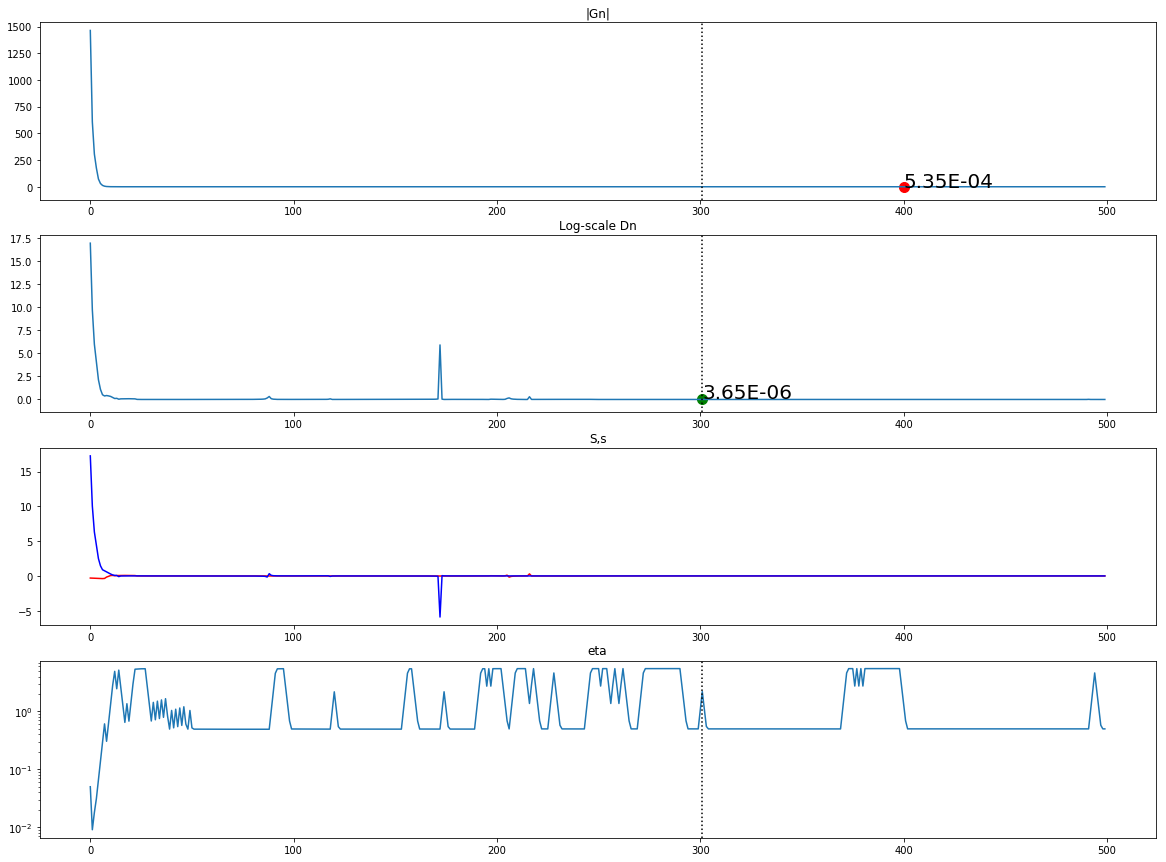

In [8]:
from decimal import Decimal
#####DEBUG#####
#find minimal Gn, Dn
minG = np.min(listG)
iminG = np.argmin(listG)
minD = np.min(np.absolute(listD))
iminD = np.argmin(np.absolute(listD))

fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(listG)
ax1.scatter(iminG,minG, c = 'r', s = 100)
decG = '%.2E' % Decimal(minG)
ax1.annotate(decG, (iminG,minG+0.1), fontsize=20)
ax1.set_title('|Gn|')
ax1.axvline(iminD, c = 'black', ls = 'dotted')

ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(listD)
ax2.scatter(iminD,minD, c = 'g', s = 100)
decD = '%.2E' % Decimal(minD)
ax2.annotate(decD, (iminD,minD+0.1), fontsize=20)
ax2.axvline(iminD, c = 'black', ls = 'dotted')
ax2.set_title('Log-scale Dn')

ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(listS, c = 'r')
ax3.plot(lists, c = 'b')
ax3.set_title('S,s');

ax4 = fig.add_subplot(4, 1, 4)
ax4.semilogy(listeta)
ax4.axvline(iminD, c = 'black', ls = 'dotted')
ax4.set_title('eta');
###############

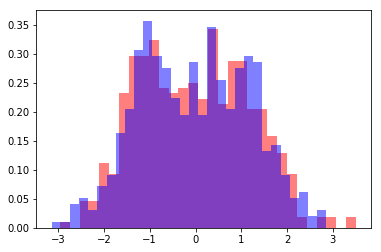

In [12]:
a,b = z[:da],z[da:]
Txa = (1+a[0])*x + a[1] + a[2]*a[3]**2 * (x+a[4]) * np.exp(-0.5*(a[3]*(x+a[4]))**2)
#plots
bins = 30
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
# plt.show()
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);
# plt.show()

In [21]:
print(np.var(y))
print(np.var(Txa))

1.5809834703675418
1.5267218522284383


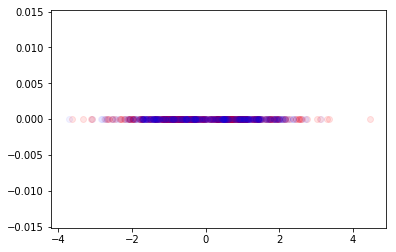

In [22]:
plt.scatter(Txa,np.zeros_like(Txa),color='red',alpha = 0.1);
plt.scatter(y,np.zeros_like(y), color='blue',alpha = 0.05);
# plt.scatter(x,np.zeros_like(x), color='green',alpha = 0.3);

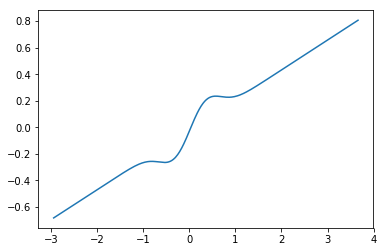

In [23]:
index = np.argsort(x)
u = Txa-x
plt.plot(x[index],u[index]);

## Packaged Algorithm

In [6]:
def local_ot(x,y,Niter=100):#Updates eta using Dn instead of Gn
    try:
        Nx,d = x.shape
    except ValueError:
        Nx = len(x)
        d = 1
    Ny = len(y)
    da = 2+2*d+d**2
    db = 3*d+6

    #Precomputed data, (twisted) gradient and Hessian
    xh = np.concatenate([x.reshape(Nx,d),np.ones((Nx,d))],axis=1)

    gammaA = 2*1e-1 #alpha regularization parameter 
    gammaB = 2*1e-1 #beta regularization parameter

    def GH(a,b,eps,D):

        #precomputations
        Tx0 = (1+a[0])*x+a[1] 
        xa4 = x + a[4]
        a3xa4 = a[3]*xa4
        a3xa42 = a3xa4**2
        expo = np.exp(-0.5*a3xa42)
        Tx1 = a[2]*a[3]*a3xa4*expo
        Tx = Tx0 + Tx1

        g0y = 0.5*b[0]*y**2 + b[1]*y + b[2]
        argexpy1 =  (b[4]*(y + b[5]))**2
        expoy1 = np.exp(-0.5*argexpy1)
        argexpy2 =  (b[7]*(y + b[8]))**2
        expoy2 = np.exp(-0.5*argexpy2)
        g1y = b[3]*expoy1
        g2y = b[6]*expoy2
        gy = g0y + g1y + g2y
        g0Tx = 0.5*b[0]*Tx**2 + b[1]*Tx + b[2]
        argexpT1 =  (b[4]*(Tx + b[5]))**2
        expoT1 = np.exp(-0.5*argexpT1)
        argexpT2 =  (b[7]*(Tx + b[8]))**2
        expoT2 = np.exp(-0.5*argexpT2)
        g1Tx = b[3]*expoT1
        g2Tx = b[6]*expoT2
        gTx = g0Tx + g1Tx + g2Tx   

        g0pTx = b[0]*Tx + b[1]
        g1pTx = -b[4]**2 * (Tx+b[5])*g1Tx
        g2pTx = -b[7]**2 * (Tx+b[8])*g2Tx
        gpTx = g0pTx + g1pTx + g2pTx

        daT = np.zeros((Nx,da))
        daT[:,0] = x
        daT[:,1] = np.ones(Nx)
        daT[:,2] = expo*a[3]*a3xa4
        daT[:,3] = a[2] * a3xa4 * expo * (2.0 - a3xa42)
        daT[:,4] = a[2]*a[3]**2 * expo * (1.0 - a3xa42)

        #gradient w.r.t. a
        penalty_a = np.array([0*a[0],0*a[1]/D**2,0*a[2],eps**2*a[3]*np.exp((eps*a[3])**2)-1.0/(D**2 * a[3]**3),1*a[4]/(10*D**2)]) 
        daL = (1.0/Nx) * np.einsum('i,ik->k',gpTx,daT) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penalty_a

        expgy = np.exp(gy)
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = 0.5*y**2
        dbgT[:,0] = 0.5*Tx**2
        dbgy[:,1] = y
        dbgT[:,1] = Tx
        dbgy[:,2] = np.ones(Ny)
        dbgT[:,2] = np.ones(Nx) 
        dbgy[:,3] = expoy1
        dbgT[:,3] = expoT1
        dbgy[:,4] = -b[4]*(y+b[5])**2 * g1y
        dbgT[:,4] = -b[4]*(Tx+b[5])**2 * g1Tx
        dbgy[:,5] = -b[4]**2 * (y+b[5])*g1y
        dbgT[:,5] = -b[4]**2 * (Tx+b[5])*g1Tx
        dbgy[:,6] = expoy2
        dbgT[:,6] = expoT2
        dbgy[:,7] = -b[7]*(y+b[8])**2 * g2y
        dbgT[:,7] = -b[7]*(Tx+b[8])**2 * g2Tx
        dbgy[:,8] = -b[7]**2 * (y+b[8])*g2y
        dbgT[:,8] = -b[7]**2 * (Tx+b[8])*g2Tx
        #gradient w.r.t. b
        penalty_b = np.array([0,0,0,0,eps**2*b[4]*np.exp((eps*b[4])**2)-1*1/(D**2 *b[4]**3),1*b[5]/(10*D**2)-1*2*eps**2 *(b[5]-b[8])**(-3),0,eps**2*b[7]*np.exp((eps*b[7])**2)-1*1/(D**2 *b[7]**3),1*b[8]/(10*D**2)+ 1*2*eps**2 *(b[5]-b[8])**(-3)])
        dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

        #twisted gradient
        G = np.concatenate([daL,-dbL],axis=0)

        g0ppTx = b[0]*np.ones(Nx)
        g1ppTx = -b[4]**2 *g1Tx*(1.0-b[4]**2 * (Tx+b[5]))
        g2ppTx = -b[7]**2 *g2Tx*(1.0-b[7]**2 * (Tx+b[8]))
        gppTx = g0ppTx+g1ppTx+g2ppTx

        daaT = np.zeros((Nx,da,da))
        daaT[:,2,3] = a3xa4 * expo * (2.0 - a3xa42)
        daaT[:,2,4] = a[3]**2 * expo * (1.0 - a3xa42)
        daaT[:,3,3] = a[2] * xa4 * expo * (2.0-3*a3xa42-a3xa42*(2.0-a3xa42))
        daaT[:,3,4] = a[2]*a[3] * expo * (2.0 + a3xa42*(a3xa42-5.0))
        daaT[:,4,4] = -a[2]*a[3]**4 *xa4 * expo * (3.0 + a3xa42)
        #Hessian w.r.t. aa
    #     penaltyH_a = np.eye(da)
    #     penaltyH_a[1,1] = 1.0/D**2
        penaltyH_a = np.zeros((da,da))
        penaltyH_a[4,4] = 1*1.0/(10*D**2)
        penaltyH_a[3,3] = eps**2 * np.exp((a[3]*eps)**2)*(1.0+2.0*a[3]*eps**2) + 3/(D**2 * a[3]**4)
        daaL = (1.0/Nx)*(np.einsum('i,ikl->kl',gpTx,daaT) + np.einsum('i,ik,il->kl',gppTx,daT,daT)) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penaltyH_a

        dbgpTx = np.zeros((Nx,db))
        dbgpTx[:,0] = Tx
        dbgpTx[:,1] = np.ones(Nx)
        dbgpTx[:,3] = -b[4]**2 * (Tx+b[5]) * expoT1
        dbgpTx[:,4] = b[4]*b[3]*(Tx+b[5])*expoT1*(-2.0+b[4]**2 * (Tx+b[5])**2)
        dbgpTx[:,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
        dbgpTx[:,6] = -b[7]**2 * (Tx+b[8]) * expoT2
        dbgpTx[:,7] = b[7]*b[6]*(Tx+b[8])*expoT2*(-2.0+b[7]**2 * (Tx+b[8])**2)
        dbgpTx[:,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)

        #Hessian w.r.t. ab
        dabL = (1.0/Nx)*np.einsum('in,ik->kn',dbgpTx,daT)

        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        dbbgy[:,3,4] = -b[4]*(y+b[5])**2 * expoy1
        dbbgT[:,3,4] = -b[4]*(Tx+b[5])**2 * expoT1
        dbbgy[:,3,5] = -b[4]**2 * (y+b[5])* expoy1
        dbbgT[:,3,5] = -b[4]**2 * (Tx+b[5])* expoT1
        dbbgy[:,4,4] = b[3]*(y+b[5])**2 * expoy1 * (-1.0+argexpy1)
        dbbgT[:,4,4] = b[3]*(Tx+b[5])**2 * expoT1 * (-1.0+argexpT1)
        dbbgy[:,4,5] = b[3]*b[4]*(y+b[5])*expoy1*(-2.0+b[4]*(y+b[5]))
        dbbgT[:,4,5] = b[3]*b[4]*(Tx+b[5])*expoT1*(-2.0+b[4]*(Tx+b[5]))
        dbbgy[:,5,5] = b[3]*b[4]**2 * expoy1*(-1.0+argexpy1)
        dbbgT[:,5,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
        dbbgy[:,6,7] = -b[7]*(y+b[8])**2 * expoy2
        dbbgT[:,6,7] = -b[7]*(Tx+b[8])**2 * expoT2
        dbbgy[:,6,8] = -b[7]**2 * (y+b[8])* expoy2
        dbbgT[:,6,8] = -b[7]**2 * (Tx+b[8])* expoT2
        dbbgy[:,7,7] = b[6]*(y+b[8])**2 * expoy2 * (-1.0+argexpy2)
        dbbgT[:,7,7] = b[6]*(Tx+b[8])**2 * expoT2 * (-1.0+argexpT2)
        dbbgy[:,7,8] = b[6]*b[7]*(y+b[8])*expoy2*(-2.0+b[7]*(y+b[8]))
        dbbgT[:,7,8] = b[6]*b[7]*(Tx+b[8])*expoT2*(-2.0+b[7]*(Tx+b[8]))
        dbbgy[:,8,8] = b[6]*b[7]**2 * expoy2*(-1.0+argexpy2)
        dbbgT[:,8,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
        #symmetrize tensors
        dbbgy = dbbgy + np.transpose(dbbgy,(0,2,1))
        dbbgy[:,np.arange(db),np.arange(db)] *= 0.5
        dbbgT = dbbgT + np.transpose(dbbgT,(0,2,1))
        dbbgT[:,np.arange(db),np.arange(db)] *= 0.5

        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        #Hessian w.r.t. bb
        penaltyH_b = np.zeros((db,db))
        penaltyH_b[5,5] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
        penaltyH_b[8,8] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
        penaltyH_b[5,8] = -1*6*eps**2 *(b[5]-b[8])**(-4)
        penaltyH_b[8,5] = -1*6*eps**2 *(b[5]-b[8])**(-4)
        penaltyH_b[4,4] = eps**2 * np.exp((b[4]*eps)**2)*(1.0+2.0*b[4]*eps**2) + 1*3/(D**2 * b[4]**4)
        penaltyH_b[7,7] = eps**2 * np.exp((b[7]*eps)**2)*(1.0+2.0*b[7]*eps**2) + 1*3/(D**2 * b[7]**4)
        dbbL = (1.0/Nx)*np.sum(dbbgT,axis=0) - (1.0/Ny)*np.einsum('jnm,j->nm',(dbbgy+dbgdbg),expgy) - gammaB*penaltyH_b

        #Twisted Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = -dabL.T
        H[da:,da:] = -dbbL
        return(G,H)
     
    #local minimax algorithm, rejction using G, update eta with D
#     Niter = 50
    eps = 1e-4
    eta0 = 0.05
    eta = eta0
    etaC = 2.0
    
    #setting up initial b, and minvar,D
    vx = np.var(x)
    vy = np.var(y)
    mx = np.mean(x)
    my = np.mean(y)
    vxy = np.var(np.concatenate([x,y]))
    D = np.sqrt(vxy)
    mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[3] = 1/D
    #initial b
    b00 = np.array([1.0/vy -1.0/vx,mx/vx - my/vy,0.5*(my**2/vy-mx**2/vx)])
    b01 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
    b01[0] = 0
    b01[1] = 1/D
    b02 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
    b02[0] = 0
    b02[1] =1/D
    b0 = np.concatenate([b00,b01,b02])
    z = np.concatenate([a0,b0],axis=0)
    I = np.eye(da+db)
    minvar0 = 1e-12
    x0 = np.zeros((Nx,2))
    x0[:,0] = x
    y0 = np.zeros((Ny,2))
    y0[:,0] = y
    dsq = spatial.distance.cdist(x0,y0,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x0,x0,'sqeuclidean')
    dsq2 += 100*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
    deltainf = delta0/5 #debug

    delta = delta0
    #Initial gradient
    Gn,Hn = GH(a0,b0,delta,D)
    Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
    Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
    mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])

    a3xa4 = z[3]*(x + z[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = z[2]*expo*z[3]*a3xa4
    Tx = (1+z[0])*x+z[1] + Tx1

    Dn = abs(Mn + mn)
    ###debug####
    listG = []
    listD = []
    listS = []
    lists = []
    listeta = []
    Tx = x#debug
    gtot = 0#debug
    ############

    for n in range(Niter):
        Gnold = Gn
        Dnold = Dn

        delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        ##########################################     

        if la.norm(Gn,2)<eps:
            break
        #reject moves if bad direction
        baddir = True
        eta = 2.0*eta
        while(baddir and eta>eta0):
            eta = eta/2.0
            dz = la.solve((1.0/eta)*I+Hn,Gn)
            baddir = dz.dot(Gn)<0.0
        z = z - dz

        Gn,Hn = GH(z[:da],z[da:],delta,D)
        Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
        Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
        mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])
        Dn = abs(Mn + mn)
        #etamin = eta0/(la.norm(Gn,2)+1)#debug
        if Dn<=Dnold:
            eta = min((etaC+0.1)*eta,1.0/(1+la.norm(Gn,2)))#debug
        else:
            eta = max(eta/etaC, 0.2/(1+la.norm(Gn,2)))
    a,b = z[:da],z[da:]
    Txa = (1+a[0])*x + a[1] + a[2]*a[3]**2 * (x+a[4]) * np.exp(-0.5*(a[3]*(x+a[4]))**2)
    return(Txa,a,b)

/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:215: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:216: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:255: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we adv

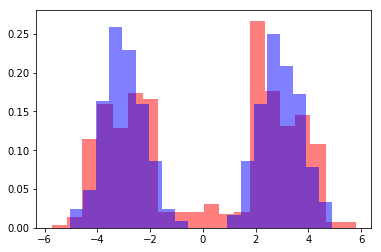

In [26]:
Txa,a,b = local_ot(x,y,Niter=100)
#plots
bins = 20
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

# Global Algorithm

## Open Version

In [7]:
def idx_choice(x,y):
    Nx = len(x)
    Ny = len(y)
    #assignement for x:
    idxx = np.zeros(Nx)
    q = int(Nx/Ny)
    r = Nx % Ny
    for i in range(q):
        idxx[i*Ny:(i+1)*Ny] = np.random.choice(np.arange(Ny),Ny,replace=False)
    idxx[-r:] = np.random.choice(np.arange(Ny),r,replace=False)
    #assignement for y:
    idxy = np.zeros(Ny)
    q = int(Ny/Nx)
    r = Ny % Nx
    for i in range(q):
        idxy[i*Nx:(i+1)*Nx] = np.random.choice(np.arange(Nx),Nx,replace=False)
    idxy[-r:] = np.random.choice(np.arange(Nx),r,replace=False)
    return(y[idxx.astype(int)],x[idxy.astype(int)])   

0.0


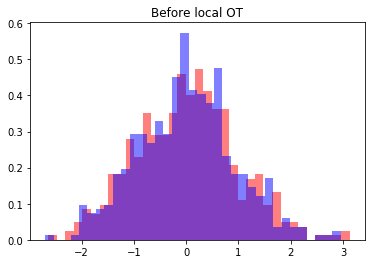

/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:215: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:216: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:255: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we adv

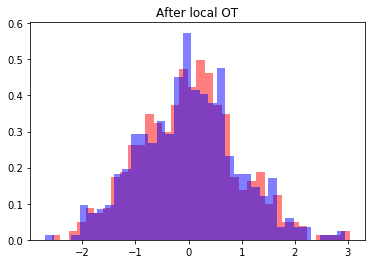

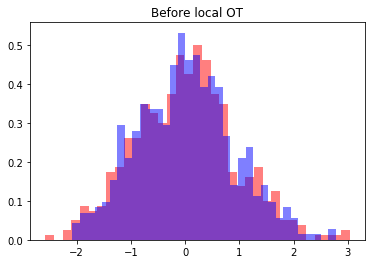

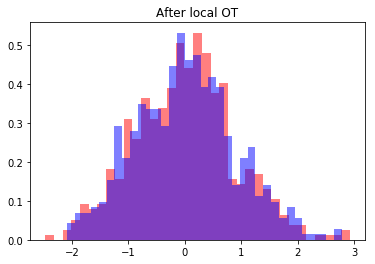

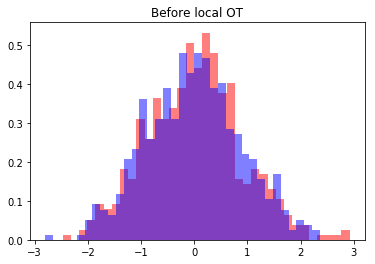

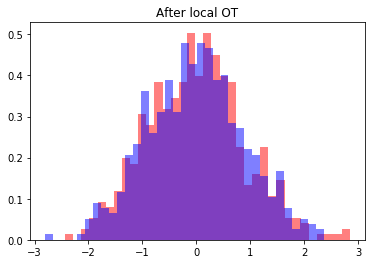

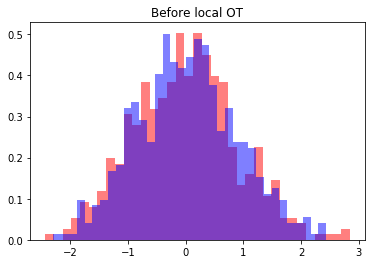

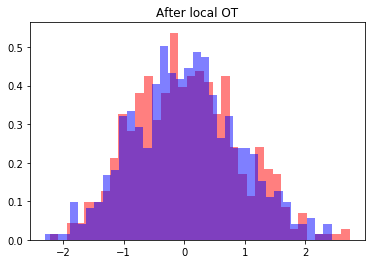

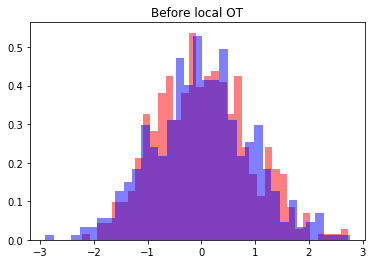

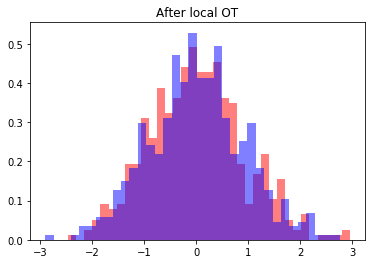

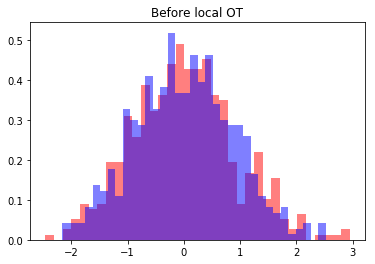

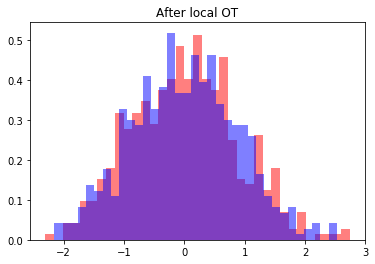

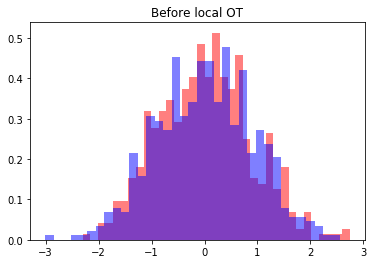

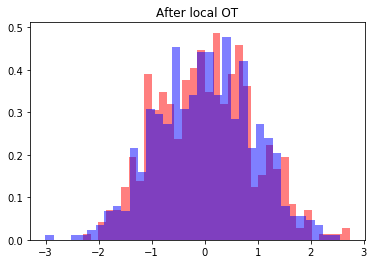

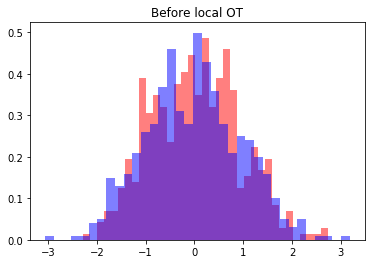

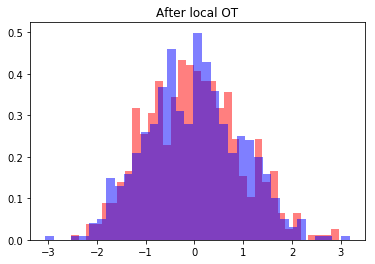

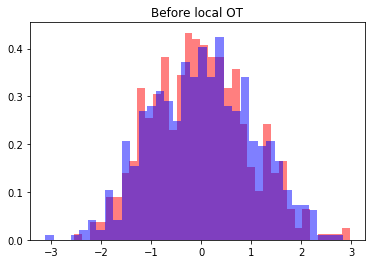

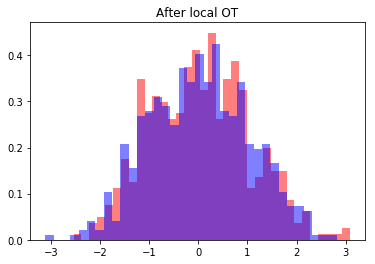

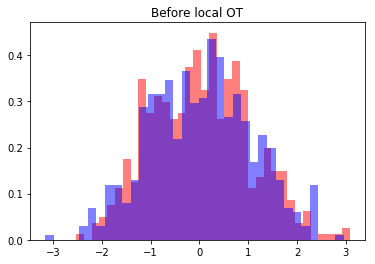

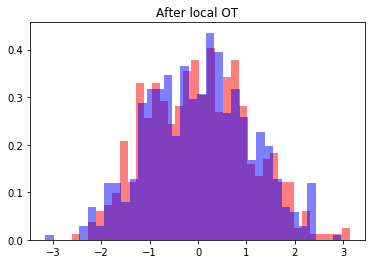

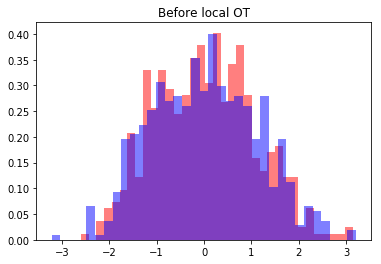

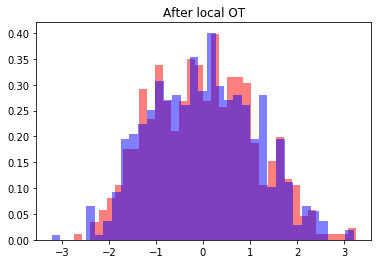

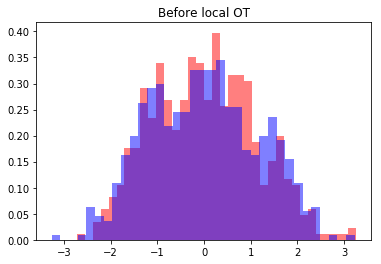

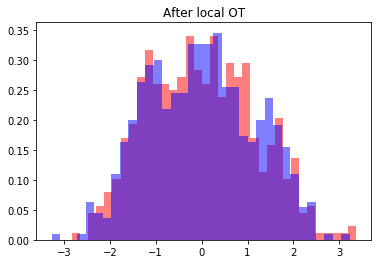

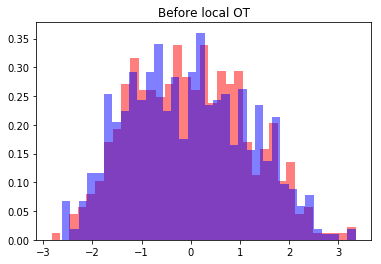

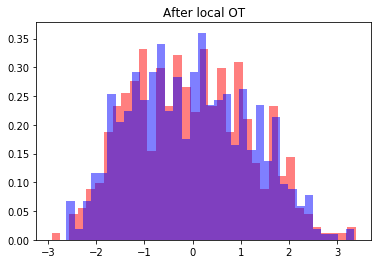

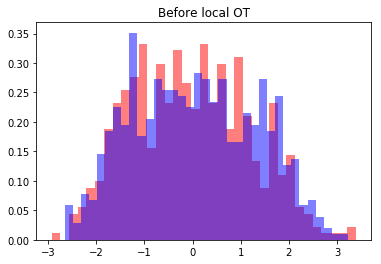

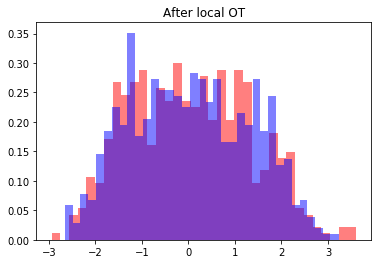

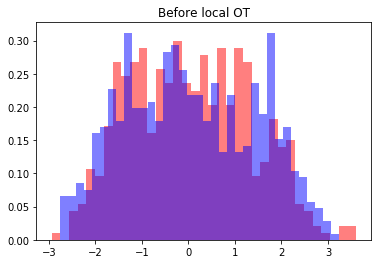

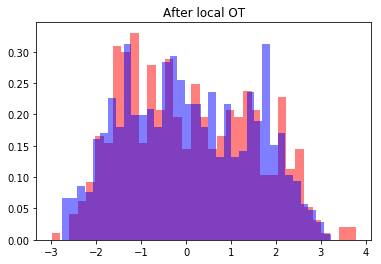

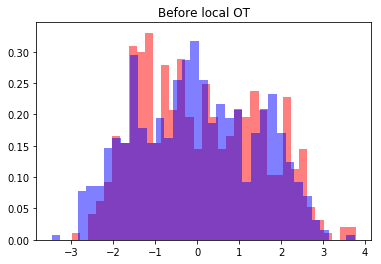

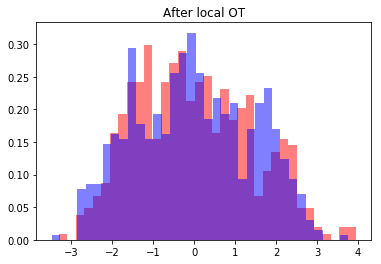

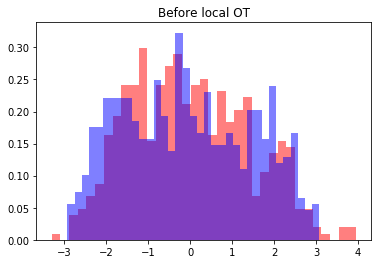

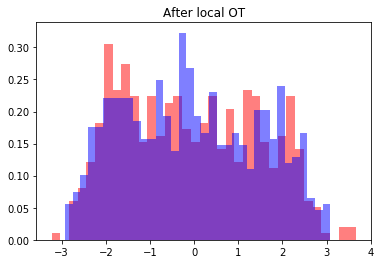

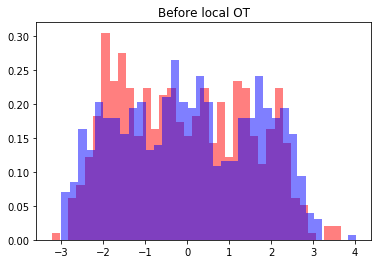

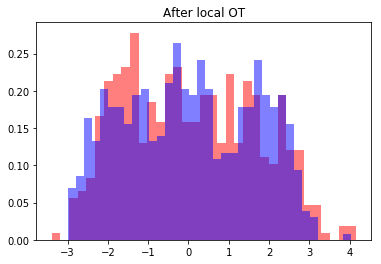

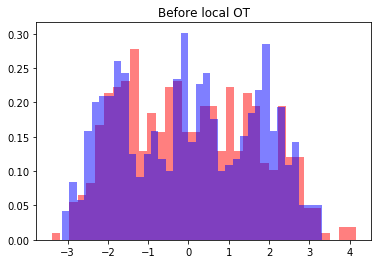

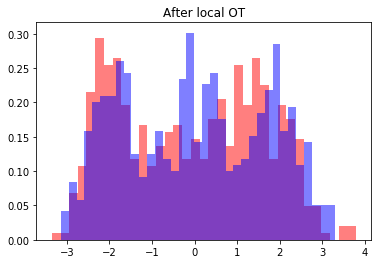

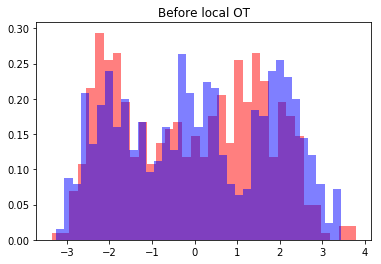

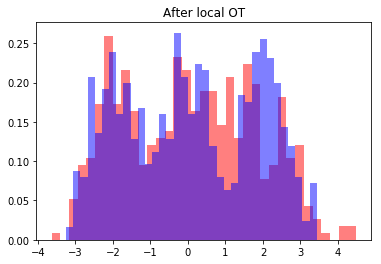

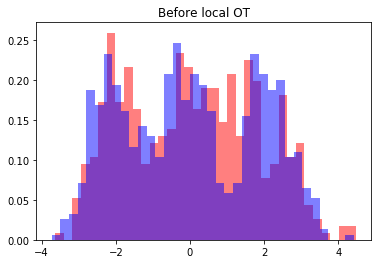

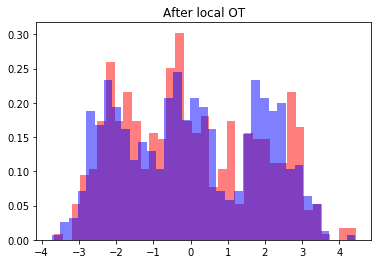

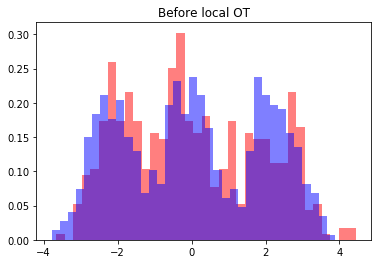

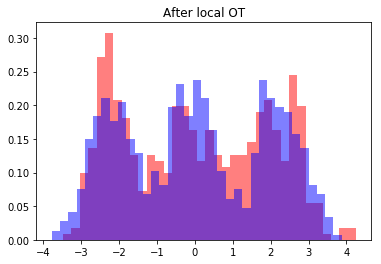

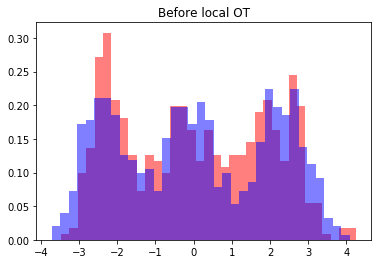

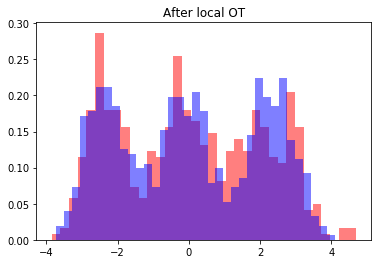

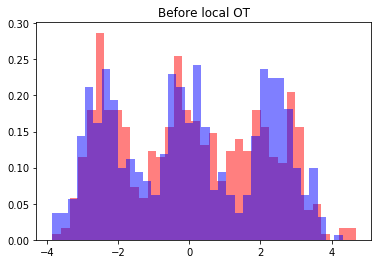

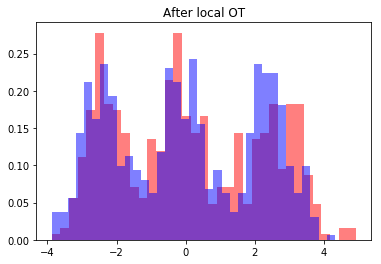

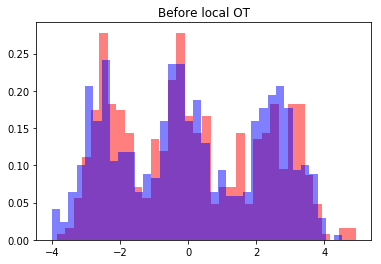

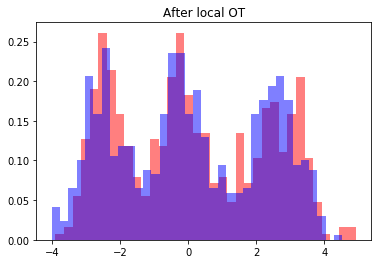

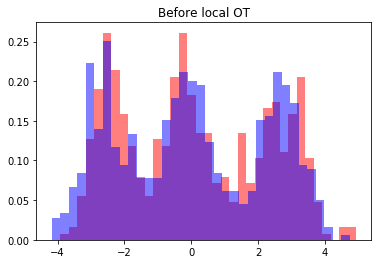

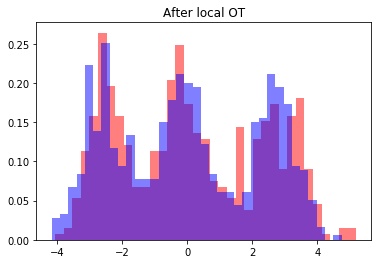

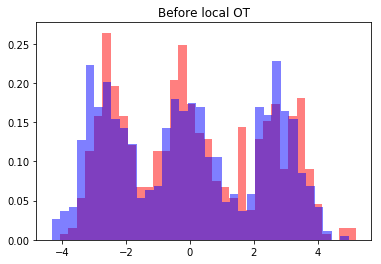

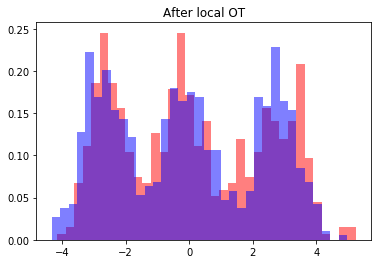

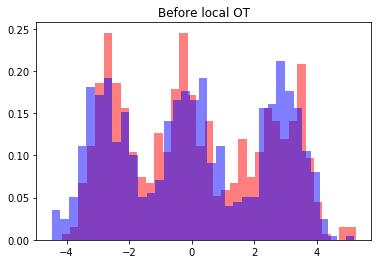

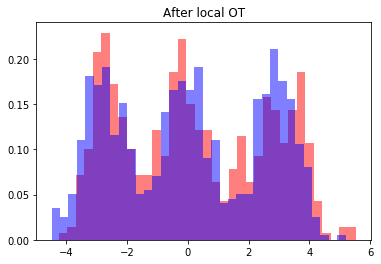

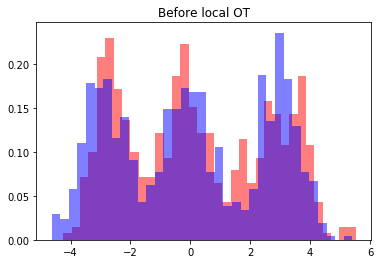

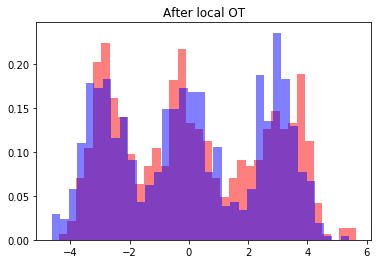

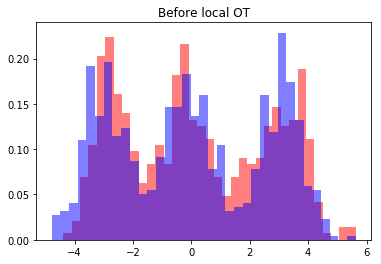

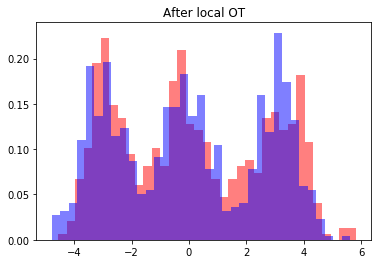

1.0


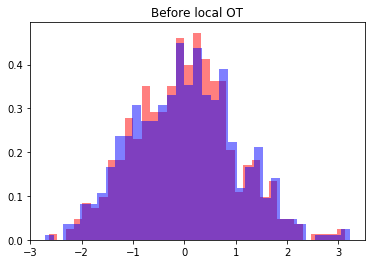

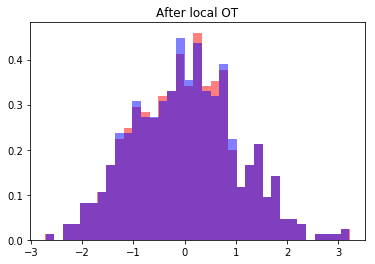

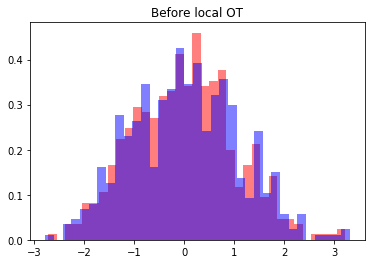

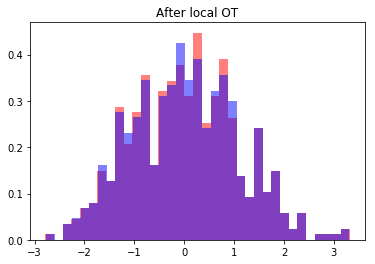

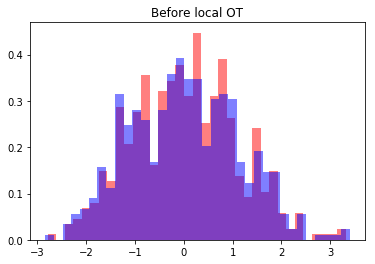

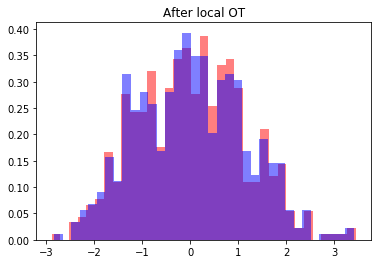

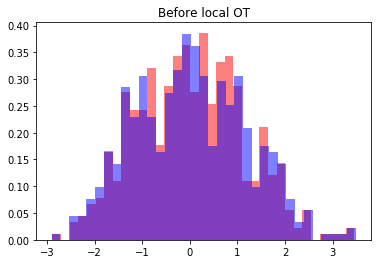

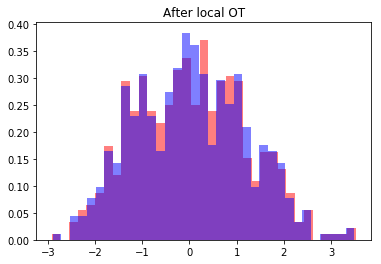

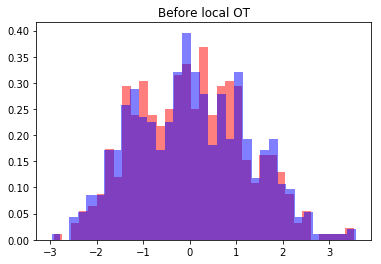

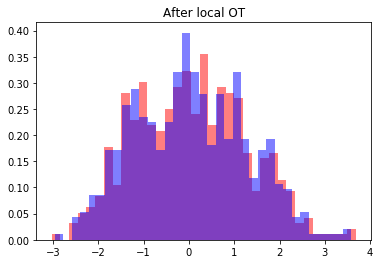

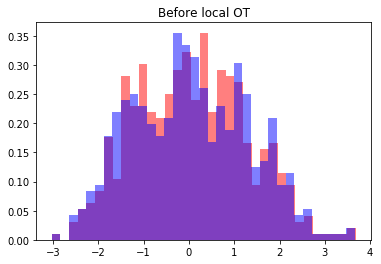

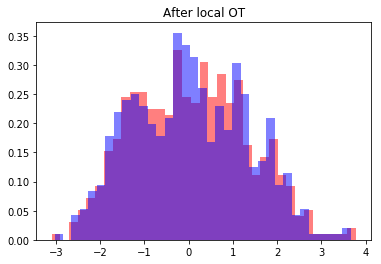

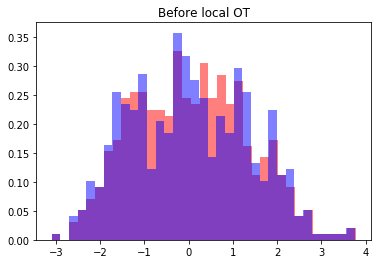

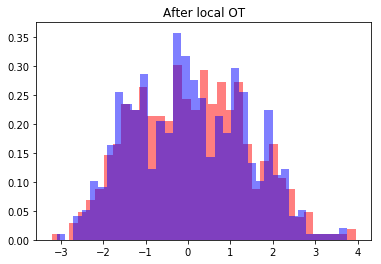

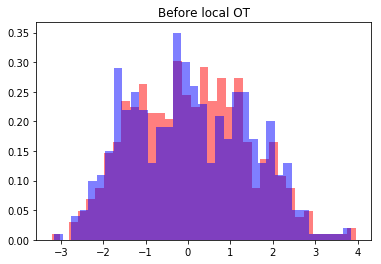

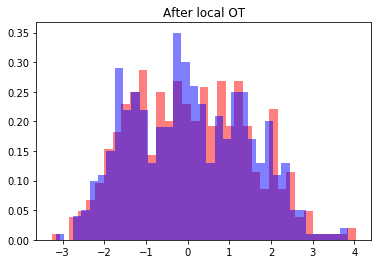

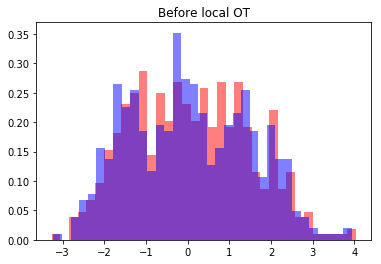

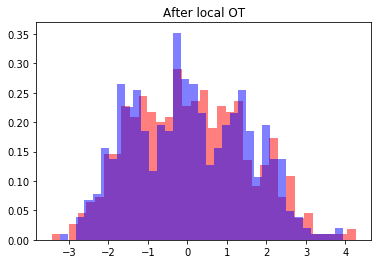

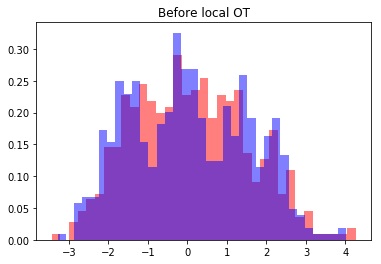

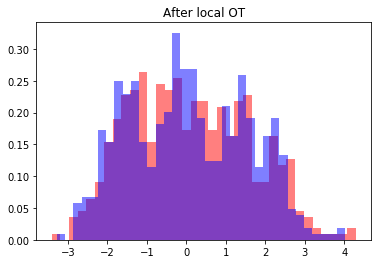

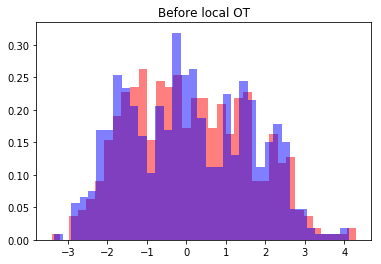

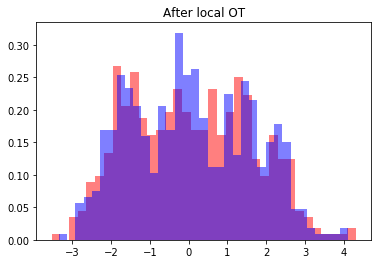

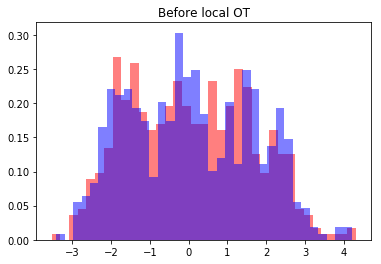

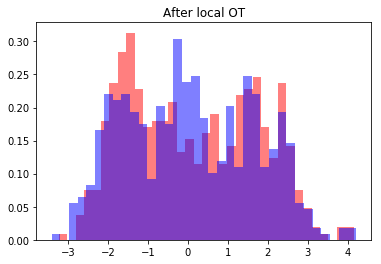

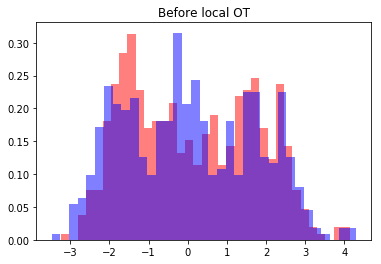

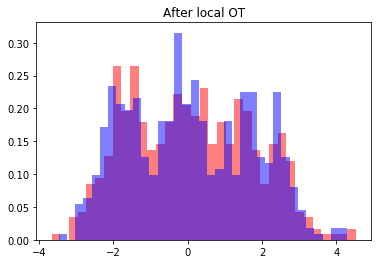

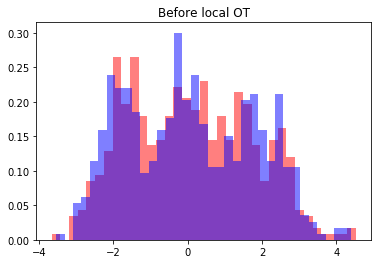

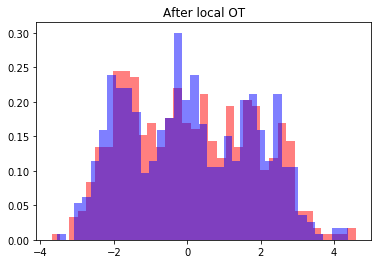

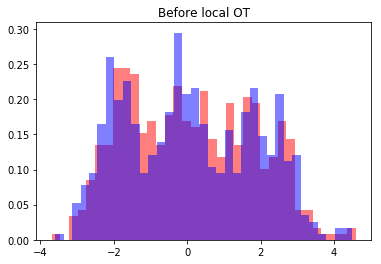

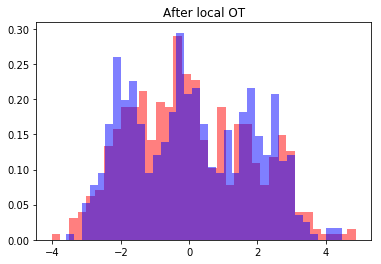

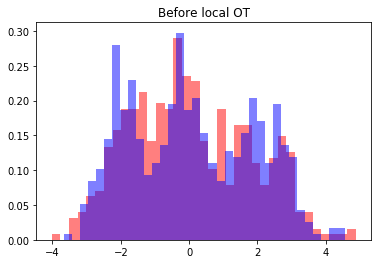

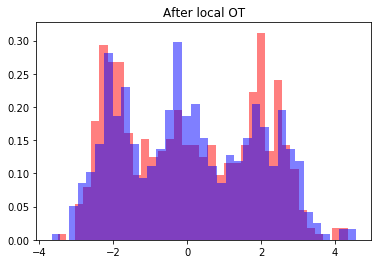

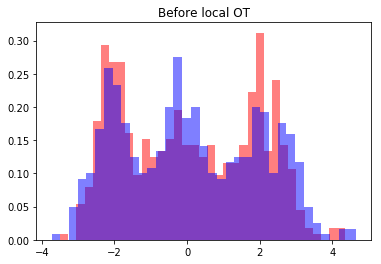

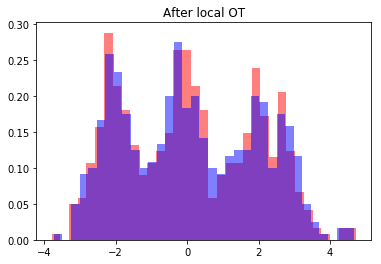

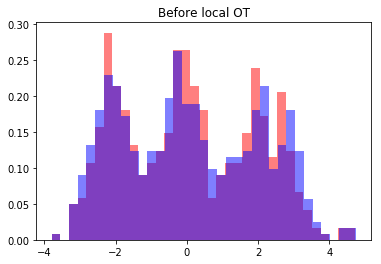

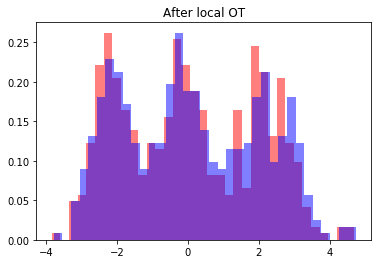

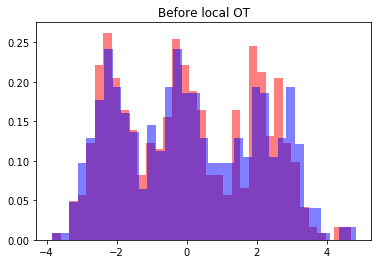

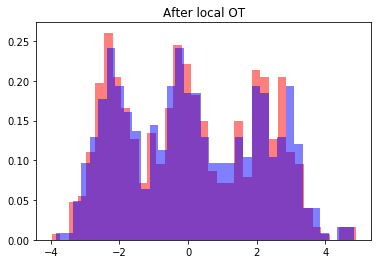

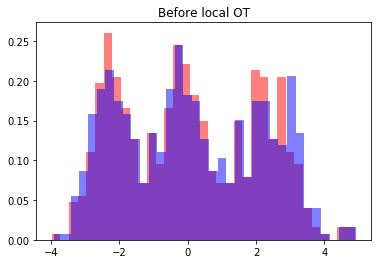

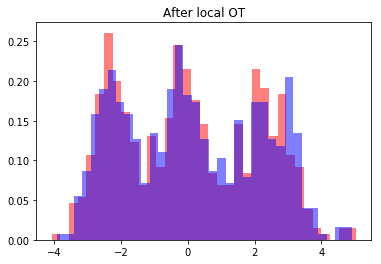

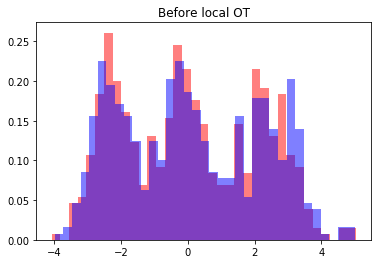

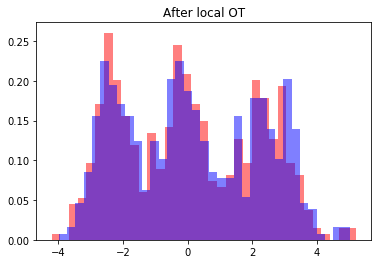

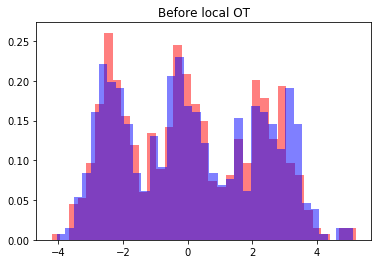

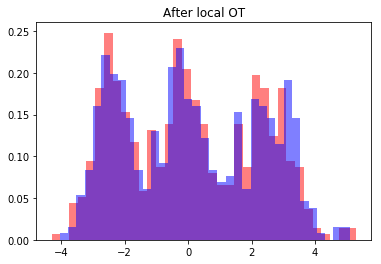

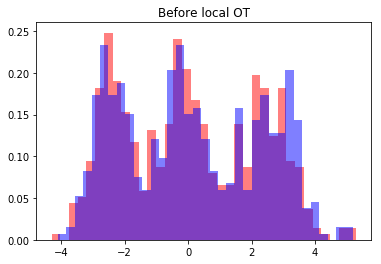

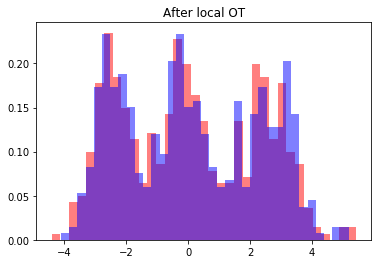

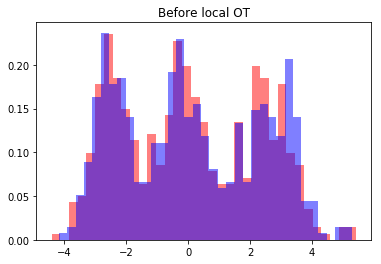

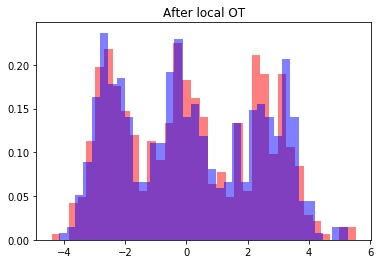

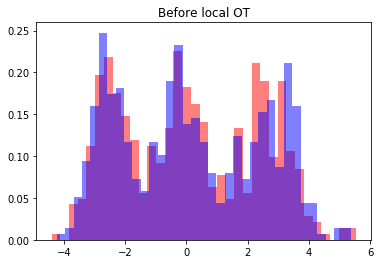

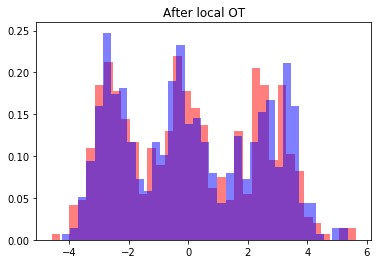

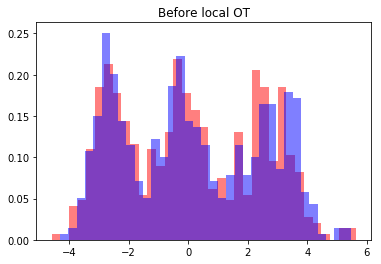

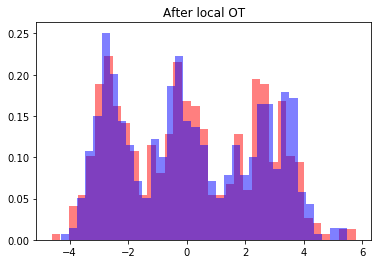

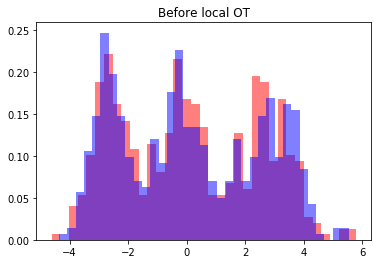

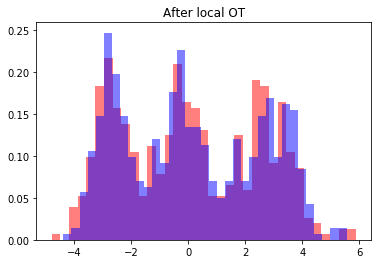

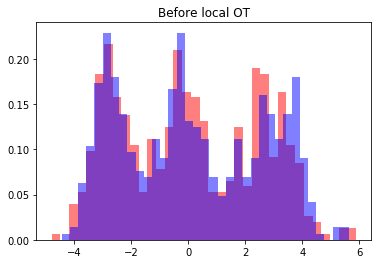

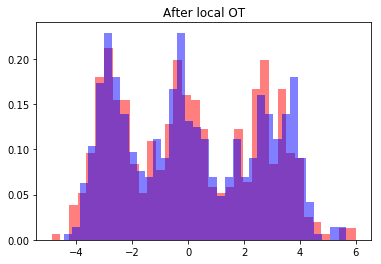

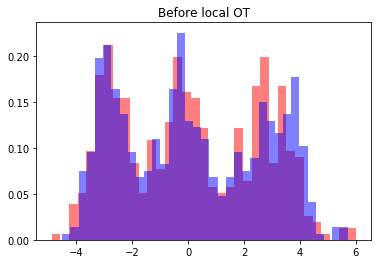

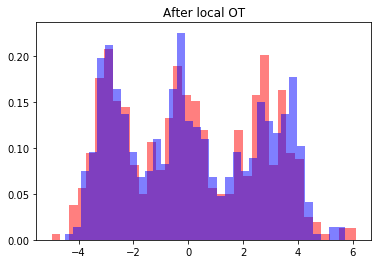

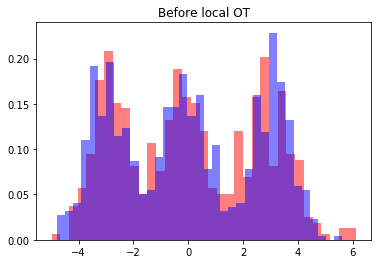

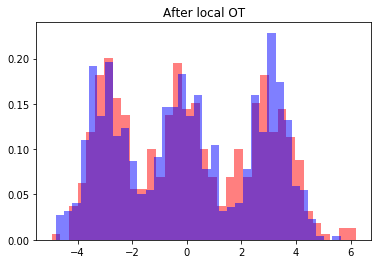

done


In [11]:
K = 30
Maxiter = 100
tol = 1e-2

Nx = len(x)
Ny = len(y) 
a_maps = K*[0]
b_maps = K*[0]

# #Initialize intermediary distributions with random selections for x
# x_K = np.array([y[np.random.randint(0,Ny)] for i in range(Nx)])
# mu = []
# mu.append(x)
# for k in range(1,K):
#     z = (1-k/K)*x+(k/K)*x_K
#     mu.append(z)
# mu.append(y)

#Initialize intermediary distributions both from x and y
x_K, y_0 = idx_choice(x,y)
mu = []
mu.append(x)
for k in range(1,K):
    zx = np.random.choice((1-k/K)*x+(k/K)*x_K,int(Nx*(1-k/K)),replace=False)
    zy = np.random.choice((1-k/K)*y_0+(k/K)*y,int(Ny*k/K),replace=False)
    z = np.concatenate([zx,zy])
    mu.append(z)
mu.append(y)
    

for niter in range(Maxiter):
    print(niter/Maxiter * 100)#debug
    x_Kold=x_K
    #solve local OT's
    z = x
    for k in range(1,K+1):
#         #plot before transport
        bins = 35
        plt.hist(z,density=True, bins=bins, color='red', alpha = 0.5);
        plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);
        plt.title('Before local OT')
        plt.draw()
        plt.show()
        
        #solve local transport problem
        Tloc,a,b = local_ot(z,mu[k],Niter=250)
        
        #plot after transport
        bins = 35
        plt.hist(Tloc,density=True, bins=bins, color='red', alpha = 0.5);
        plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);
        plt.title('After local OT')
        plt.draw()
        plt.show()
        
        a_maps[k-1] = a
        b_maps[k-1] = b
        z = Tloc
    x_K = z
    if (1/Nx)*np.linalg.norm(x_K-x_Kold,2)<tol:
        break
    #update intermediate distributions
    for k in range(1,K):
        mu[k] = (1-k/K)*x+(k/K)*x_K

print('done')

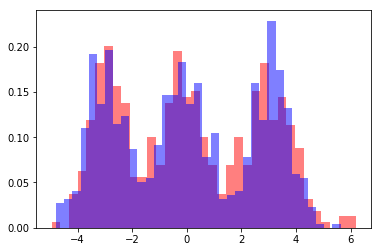

In [12]:
#plots
bins = 35
plt.hist(x_K,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

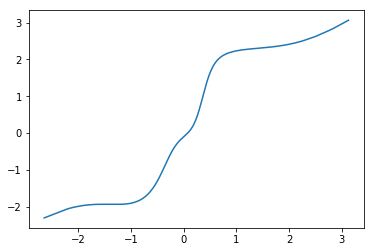

In [13]:
index = np.argsort(x)
u = x_K-x
plt.plot(x[index],u[index]);

## Packaged version

In [ ]:
def sot(x,y,K=10,tol=1e-1,Maxiter=50):
    Nx = len(x)
    Ny = len(y) 
    c_maps = K*[0]
    a_maps = K*[0]
    b_maps = K*[0]
    #Initialize intermediary distributions
    x_K = np.array([y[np.random.randint(0,Ny)] for i in range(Nx)])
    mu = []
    mu.append(x)
    for k in range(1,K):
        z = (1-k/K)*x+(k/K)*x_K
        mu.append(z)
    mu.append(y)
    
#     #plots
#     plt.figure(figsize=(20, 4))
#     for i in range(K+1):
#         plt.subplot(1, K+1, i+1)
#         plt.scatter(mu[i],np.zeros_like(mu[i]))
#     plt.draw()
#     plt.show()
    
    for niter in range(Maxiter):
        print(niter/Maxiter * 100)#debug
        x_Kold=x_K
        #solve local OT's
        z = x
        for k in range(1,K+1):
            Tloc,c,a,b = local_ot2(z,mu[k])
            c_maps[k-1] = c
            a_maps[k-1] = a
            b_maps[k-1] = b
            z = Tloc
        x_K = z
        if (1/Nx)*np.linalg.norm(x_K-x_Kold,2)<tol:
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = (1-k/K)*x+(k/K)*x_K
        
#         #plots
#         plt.figure(figsize=(20, 4))
#         for i in range(K+1):
#             plt.subplot(1, K+1, i+1)
#             plt.scatter(mu[i],np.zeros_like(mu[i]))
#         plt.draw()
#         plt.show()
        
    return(x_K, c_maps, a_maps, b_maps)

In [ ]:
Txa,c,a,b = sot(x,y)

In [ ]:
#plots
bins = 35
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

In [ ]:
plt.scatter(Txa,np.zeros_like(Txa),color='red',alpha = 0.3);
plt.scatter(y,np.zeros_like(y), color='blue',alpha = 0.15);
# plt.scatter(x,np.zeros_like(x), color='green',alpha = 0.3);

In [ ]:
index = np.argsort(x)
u = Txa-x
plt.plot(x[index],u[index]);

In [ ]:
sumb = [np.sum([b[i][k] for i in range(len(b))]) for k in range(len(b[0]))]

In [ ]:
#Grid
m = min(min(x),min(y))
M = max(max(x),max(y))
NumKnots = 5
delta = (M-m)/(NumKnots-1)
g = np.array([m+delta*i for i in range(NumKnots)])
#Splines
def F1(z):
    if z<0:
        return 0
    elif z>1:
        return z-1/2
    else:
        return z**2/2
def F2(z):
    if z<0:
        return 0
    elif z>1:
        return z-2/3
    else:
        return z**3/3
def DF1(z):
    if z<0:
        return 0
    elif z>1:
        return 1
    else:
        return z
def DF2(z):
    if z<0:
        return 0
    elif z>1:
        return 1
    else:
        return z**2
def D2F1(z):
    if z<0:
        return 0
    elif z>1:
        return 0
    else:
        return 1
def D2F2(z):
    if z<0:
        return 0
    elif z>1:
        return 0
    else:
        return 2*z 
f = []
Df = []
D2f = []
f.append(lambda z: 1)
f.append(lambda z: z)
Df.append(lambda z: 0)
Df.append(lambda z: 1)
D2f.append(lambda z: 0)
D2f.append(lambda z: 0)
for t in range(NumKnots-1):
    f.append(lambda z, tl=t: F1((z-g[tl])/(g[tl+1]-g[tl])))
    f.append(lambda z, tl=t: F2((z-g[tl])/(g[tl+1]-g[tl])))
    Df.append(lambda z, tl=t: (1/(g[tl+1]-g[tl]))*DF1((z-g[tl])/(g[tl+1]-g[tl])))
    Df.append(lambda z, tl=t: (1/(g[tl+1]-g[tl]))*DF2((z-g[tl])/(g[tl+1]-g[tl])))
    D2f.append(lambda z, tl=t: (1/(g[tl+1]-g[tl])**2)*D2F1((z-g[tl])/(g[tl+1]-g[tl])))
    D2f.append(lambda z, tl=t: (1/(g[tl+1]-g[tl])**2)*D2F2((z-g[tl])/(g[tl+1]-g[tl])))
T = 2*NumKnots

In [ ]:
gtest = lambda z: np.sum([sumb[k]*f[k](z) for k in range(len(f))])

In [ ]:
zs = np.arange(-6,6,14/20)
plt.plot(zs,[gtest(zs[k]) for k in range(len(zs))])